<a href="https://colab.research.google.com/github/bparry32/bparry32/blob/main/ASA_NWSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install itscalledsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.6 MB/s eta 0:00:00


In [14]:
import os
import pandas as pd
from itscalledsoccer.client import AmericanSoccerAnalysis
from google.colab import drive

# 1. Setup Environment and Google Drive
drive.mount('/content/drive')
BASE_PATH = "/content/drive/My Drive/Data/Football"
os.makedirs(BASE_PATH, exist_ok=True)

# 2. Initialize Client
asa_client = AmericanSoccerAnalysis()

class NWSLBulkPuller:
    def __init__(self, league, seasons):
        self.league = league
        self.seasons = seasons  # Now a list: [2023, 2024, 2025]

    def download_matches_bulk(self):
        print(f"Downloading matches for seasons {self.seasons}...")
        # ASA handlers accept lists for seasons
        games = asa_client.get_games(leagues=self.league, seasons=self.seasons)

        # Original transformations
        games['asa_competition_name'] = self.league
        games['date_time_utc'] = pd.to_datetime(games['date_time_utc'])
        games['match_date'] = games['date_time_utc'].dt.date

        save_path = os.path.join(BASE_PATH, f"{self.league}_bulk_matches.csv")
        games.to_csv(save_path, index=False)
        print(f"Saved: {save_path}")

    def download_player_match_bulk(self):
        print(f"Downloading player match data for seasons {self.seasons}...")

        # Pulling g+ for all seasons at once
        gadded = asa_client.get_player_goals_added(
            leagues=self.league,
            season_name=self.seasons, # Passing the list
            split_by_games=True,
            split_by_teams=True,
            split_by_season=True
        ).to_dict('records')

        if gadded:
            list_key = list(gadded[0].keys())
            list_key.remove('data')
            df = pd.json_normalize(gadded, 'data', list_key)

            # Transformation to wide format
            df = df.pivot(index=['player_id','game_id','team_id','general_position','minutes_played'],
                          columns='action_type',
                          values=['goals_added_raw','goals_added_above_avg','count_actions'])
            df.columns = ['_'.join(str(s).strip() for s in col if s) for col in df.columns]
            df = df.reset_index()

            # xGoals and xPass in bulk
            p_xgoals = asa_client.get_player_xgoals(leagues=self.league, season_name=self.seasons,
                                                   split_by_games=True, split_by_season=True, split_by_teams=True)
            p_xpass = asa_client.get_player_xpass(leagues=self.league, season_name=self.seasons,
                                                  split_by_games=True, split_by_season=True, split_by_teams=True)

            # Merge and Save
            fdf = pd.merge(pd.merge(df, p_xgoals), p_xpass)
            save_path = os.path.join(BASE_PATH, f"{self.league}_bulk_player-by-match.csv")
            fdf.to_csv(save_path, index=False)

    def download_team_match_bulk(self):
        print(f"Downloading team match data for seasons {self.seasons}...")
        # Fetching xG and xPass for all seasons
        t_xgoals = asa_client.get_team_xgoals(leagues=self.league, season_name=self.seasons, split_by_season=True, split_by_game=True)
        t_xpass = asa_client.get_team_xpass(leagues=self.league, season_name=self.seasons, split_by_season=True, split_by_game=True)

        fdf = pd.merge(t_xgoals, t_xpass)
        save_path = os.path.join(BASE_PATH, f"{self.league}_bulk_team-by-match.csv")
        fdf.to_csv(save_path, index=False)
    def download_players_info(self):
        """Retrieves the master list of all players in the NWSL."""
        print(f"Downloading master player list for {self.league}...")
        # Get all players and filter by league
        players_df = asa_client.get_players(leagues=self.league)

        save_path = os.path.join(BASE_PATH, f"asa_{self.league}_players_info.csv")
        players_df.to_csv(save_path, index=False)
        print(f"Saved: {save_path}")

    def download_teams_info(self):
        """Retrieves the master list of all teams and managers in the NWSL."""
        print(f"Downloading master team and manager lists for {self.league}...")
        # Teams and Managers can be filtered by league
        teams_df = asa_client.get_teams(leagues=self.league)
        managers_df = asa_client.get_managers(leagues=self.league)

        teams_path = os.path.join(BASE_PATH, f"asa_{self.league}_teams_info.csv")
        managers_path = os.path.join(BASE_PATH, f"asa_{self.league}_managers_info.csv")

        teams_df.to_csv(teams_path, index=False)
        managers_df.to_csv(managers_path, index=False)
        print(f"Saved: {teams_path} and {managers_path}")
    def download_player_by_season_bulk(self):
        print(f"Downloading player season data for {self.seasons}...")

        # 1. Goals Added (g+) Season Totals
        gadded = asa_client.get_player_goals_added(
            leagues=self.league,
            season_name=self.seasons,
            split_by_teams=True,
            split_by_season=True
        ).to_dict('records')

        if gadded:
            list_key = list(gadded[0].keys())
            list_key.remove('data')
            df = pd.json_normalize(gadded, 'data', list_key)

            # Pivot to wide format
            df = df.pivot(index=['player_id','team_id','general_position','minutes_played','season_name'],
                          columns='action_type',
                          values=['goals_added_raw','goals_added_above_avg','count_actions'])
            df.columns = ['_'.join(str(s).strip() for s in col if s) for col in df.columns]
            df = df.reset_index()

            # 2. xGoals and xPass Season Totals
            p_xgoals = asa_client.get_player_xgoals(leagues=self.league, season_name=self.seasons,
                                                    split_by_season=True, split_by_teams=True)
            p_xpass = asa_client.get_player_xpass(leagues=self.league, season_name=self.seasons,
                                                  split_by_season=True, split_by_teams=True)

            # Merge all DFs
            fdf = pd.merge(pd.merge(df, p_xgoals), p_xpass)

            # 3. Add Per 90 Transformations
            fdf['nineties'] = fdf['minutes_played'] / 90

            # Select columns to normalize (exclude IDs and percentages)
            cols_to_normalize = [c for c in fdf.columns if 'goals_added' in c or 'count_actions' in c or 'xgoals' in c]
            for col in cols_to_normalize:
                fdf[f"{col}_per90"] = fdf[col] / fdf['nineties']

            fdf['asa_competition_name'] = self.league
            save_path = os.path.join(BASE_PATH, f"{self.league}_bulk_player-by-season.csv")
            fdf.to_csv(save_path, index=False)

    def download_team_by_season_bulk(self):
        print(f"Downloading team season data for {self.seasons}...")

        # 1. Team Goals Added Season Totals
        gadded = asa_client.get_team_goals_added(
            leagues=self.league,
            season_name=self.seasons,
            split_by_seasons=True
        ).to_dict('records')

        if gadded:
            list_key = list(gadded[0].keys())
            list_key.remove('data')
            df = pd.json_normalize(gadded, 'data', list_key)

            # Pivot to separate 'for' and 'against' stats
            df = df.pivot(index=['team_id','season_name','minutes'],
                          columns='action_type',
                          values=['num_actions_for','goals_added_for','num_actions_against','goals_added_against'])
            df.columns = ['_'.join(str(s).strip() for s in col if s) for col in df.columns]
            df = df.reset_index()

            # 2. Team xGoals and xPass Season Totals
            t_xgoals = asa_client.get_team_xgoals(leagues=self.league, season_name=self.seasons, split_by_season=True)
            t_xpass = asa_client.get_team_xpass(leagues=self.league, season_name=self.seasons, split_by_season=True)

            fdf = pd.merge(pd.merge(df, t_xgoals), t_xpass)
            fdf['asa_competition'] = self.league

            save_path = os.path.join(BASE_PATH, f"{self.league}_bulk_team-by-season.csv")
            fdf.to_csv(save_path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os
from google.colab import drive
# 1. Setup Environment and Google Drive
drive.mount('/content/drive')
BASE_PATH = "/content/drive/My Drive/Data/Football"
os.makedirs(BASE_PATH, exist_ok=True)
# Load asa_nwsl_players_info.csv
players_info_path = os.path.join(BASE_PATH, "asa_nwsl_players_info.csv")
nwsl_players_df = pd.read_csv(players_info_path)
print(f"Loaded {players_info_path}")
display(nwsl_players_df.head())

# Load asa_nwsl_teams_info.csv
teams_info_path = os.path.join(BASE_PATH, "asa_nwsl_teams_info.csv")
nwsl_teams_df = pd.read_csv(teams_info_path)
print(f"Loaded {teams_info_path}")
display(nwsl_teams_df.head())

# Load asa_nwsl_managers_info.csv
managers_info_path = os.path.join(BASE_PATH, "asa_nwsl_managers_info.csv")
nwsl_managers_df = pd.read_csv(managers_info_path)
print(f"Loaded {managers_info_path}")
display(nwsl_managers_df.head())

# Load nwsl_bulk_player-by-season.csv
player_season_path = os.path.join(BASE_PATH, "nwsl_bulk_player-by-season.csv")
nwsl_player_season_df = pd.read_csv(player_season_path)
print(f"Loaded {player_season_path}")
display(nwsl_player_season_df.head())

# Load nwsl_bulk_team-by-season.csv
team_season_path = os.path.join(BASE_PATH, "nwsl_bulk_team-by-season.csv")
nwsl_team_season_df = pd.read_csv(team_season_path)
print(f"Loaded {team_season_path}")
display(nwsl_team_season_df.head())

Mounted at /content/drive
Loaded /content/drive/My Drive/Data/Football/asa_nwsl_players_info.csv


,player_id,player_name,birth_date,nationality,primary_broad_position,primary_general_position,secondary_broad_position,secondary_general_position,season_name,height_ft,height_in,weight_lb,competition
0,0Oq6243Pq6,Lena Silano,2000-02-28,USA,FW,ST,MF,W,"['2023', '2024']",NaN,NaN,NaN,nwsl
1,0Oq62D2xq6,Mwanalima Jereko,1997-09-04,Kenya,MF,CM,NaN,AM,"['2024', '2025']",NaN,NaN,NaN,nwsl
2,0Oq62ob2q6,Heather Hinz,2001-06-27,USA,GK,GK,NaN,NaN,2024,NaN,NaN,NaN,nwsl
3,0Oq632XPQ6,Jenna Hellstrom,1995-04-02,Canada,DF,FB,NaN,NaN,2020,5.0,6.0,NaN,nwsl
4,0Oq63967Q6,Julia Dorsey,2000-08-08,USA,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,nwsl


Loaded /content/drive/My Drive/Data/Football/asa_nwsl_teams_info.csv


,team_id,team_name,team_short_name,team_abbreviation,competition
0,315VnJ759x,Bay FC,Bay FC,BAY,nwsl
1,4JMAk47qKg,Houston Dash,Houston,HOU,nwsl
2,4wM4Ezg5jB,Boston Breakers,Boston,BOS,nwsl
3,4wM4rZdqjB,Kansas City Current,Kansas City,KC,nwsl
4,7VqG1lYMvW,San Diego Wave FC,San Diego,SD,nwsl


Loaded /content/drive/My Drive/Data/Football/asa_nwsl_managers_info.csv


,manager_id,manager_name,nationality,competition
0,0Oq6BpAq6D,James Clarkson,USA,nwsl
1,0Oq6mKg56D,James Gabarra,USA,nwsl
2,0x5g4zPq7O,Masaki Hemmi,Japan,nwsl
3,0x5gj0ZM7O,Matt Potter,England,nwsl
4,2lqREma5r0,Paul Riley,England,nwsl


Loaded /content/drive/My Drive/Data/Football/nwsl_bulk_player-by-season.csv


,player_id,team_id,general_position,minutes_played,season_name,goals_added_raw_Dribbling,goals_added_raw_Fouling,goals_added_raw_Interrupting,goals_added_raw_Passing,goals_added_raw_Receiving,...,count_actions_Dribbling_per90,count_actions_Fouling_per90,count_actions_Interrupting_per90,count_actions_Passing_per90,count_actions_Receiving_per90,count_actions_Shooting_per90,xgoals_per90,goals_minus_xgoals_per90,xgoals_plus_xassists_per90,asa_competition_name
0,0Oq6243Pq6,aDQ0lzvQEv,ST,368,2024,0.1662,-0.0097,0.1476,-0.3243,0.8661,...,12.472826,2.201087,4.646739,23.478261,22.744565,2.445652,0.345106,0.144024,0.408693,nwsl
1,0Oq6243Pq6,aDQ0lzvQEv,W,910,2023,0.1219,0.0018,0.6230,-0.4971,0.4888,...,10.780220,1.978022,9.098901,16.318681,12.659341,1.582418,0.093580,0.005321,0.178249,nwsl
2,0Oq62D2xq6,4wM4rZdqjB,CM,4,2025,0.0000,0.0000,0.0000,-0.0079,0.0014,...,0.000000,0.000000,0.000000,45.000000,45.000000,0.000000,0.000000,0.000000,0.000000,nwsl
3,0Oq62D2xq6,4wM4rZdqjB,CM,65,2024,0.0063,-0.0099,0.0804,0.0371,0.1793,...,11.076923,2.769231,9.692308,29.076923,29.076923,5.538462,1.132200,-1.132200,1.389600,nwsl
4,0Oq63DazQ6,raMyrr25d2,FB,2553,2025,0.6761,-0.2611,0.8675,1.3296,0.4664,...,11.915394,1.656874,11.104583,45.969448,28.907168,0.458284,0.030705,0.004548,0.079135,nwsl


Loaded /content/drive/My Drive/Data/Football/nwsl_bulk_team-by-season.csv


,team_id,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,avg_vertical_distance_for,attempted_passes_against,pass_completion_percentage_against,xpass_completion_percentage_against,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference,asa_competition
0,315VnJ759x,2024,2871,56.0,4254.0,212.0,3153.0,12740.0,9703.0,350.0,...,6.2938,13015,0.7615,0.7640,-33.0348,-0.2538,6.1576,123.0892,0.1363,nwsl
1,315VnJ759x,2025,2649,31.0,3588.0,312.0,2747.0,11589.0,8760.0,303.0,...,6.4774,11638,0.7637,0.7633,5.0205,0.0431,6.5823,86.2457,-0.1049,nwsl
2,4JMAk47qKg,2021,2779,25.0,4028.0,285.0,3695.0,12225.0,8845.0,345.0,...,8.1178,13923,0.7609,0.7517,128.6021,0.9237,6.8925,-170.3201,1.2252,nwsl
3,4JMAk47qKg,2022,2899,38.0,3895.0,271.0,3702.0,12206.0,8554.0,369.0,...,8.1949,13302,0.7335,0.7368,-43.8331,-0.3295,7.4413,-221.7083,0.7536,nwsl
4,4JMAk47qKg,2023,2822,29.0,3342.0,244.0,3470.0,11581.0,8334.0,337.0,...,8.0376,12817,0.7432,0.7431,2.0735,0.0162,7.0340,-181.7863,1.0036,nwsl


In [15]:
if __name__ == "__main__":
    target_seasons = ['2021','2022','2023', '2024', '2025']
    puller = NWSLBulkPuller('nwsl', target_seasons)

# 1. Master Metadata Files
    puller.download_players_info()
    puller.download_teams_info()


    # 3. Season-Long Summaries
    puller.download_player_by_season_bulk()
    puller.download_team_by_season_bulk()

    print("\nBulk download complete, including all season-long summaries.")

Saved: /content/drive/My Drive/Data/Football/asa_nwsl_players_info.csv
Saved: /content/drive/My Drive/Data/Football/asa_nwsl_teams_info.csv and /content/drive/My Drive/Data/Football/asa_nwsl_managers_info.csv

Bulk download complete, including all season-long summaries.


In [4]:
import pandas as pd
import os

# Load asa_nwsl_players_info.csv
players_info_path = os.path.join(BASE_PATH, "asa_nwsl_players_info.csv")
nwsl_players_df = pd.read_csv(players_info_path)
print(f"Loaded {players_info_path}")
display(nwsl_players_df.head())

# Load asa_nwsl_teams_info.csv
teams_info_path = os.path.join(BASE_PATH, "asa_nwsl_teams_info.csv")
nwsl_teams_df = pd.read_csv(teams_info_path)
print(f"Loaded {teams_info_path}")
display(nwsl_teams_df.head())

# Load asa_nwsl_managers_info.csv
managers_info_path = os.path.join(BASE_PATH, "asa_nwsl_managers_info.csv")
nwsl_managers_df = pd.read_csv(managers_info_path)
print(f"Loaded {managers_info_path}")
display(nwsl_managers_df.head())

# Load nwsl_bulk_player-by-season.csv
player_season_path = os.path.join(BASE_PATH, "nwsl_bulk_player-by-season.csv")
nwsl_player_season_df = pd.read_csv(player_season_path)
print(f"Loaded {player_season_path}")
display(nwsl_player_season_df.head())

# Load nwsl_bulk_team-by-season.csv
team_season_path = os.path.join(BASE_PATH, "nwsl_bulk_team-by-season.csv")
nwsl_team_season_df = pd.read_csv(team_season_path)
print(f"Loaded {team_season_path}")
display(nwsl_team_season_df.head())

Loaded /content/drive/My Drive/Data/Football/asa_nwsl_players_info.csv


,player_id,player_name,birth_date,nationality,primary_broad_position,primary_general_position,secondary_broad_position,secondary_general_position,season_name,height_ft,height_in,weight_lb,competition
0,0Oq6243Pq6,Lena Silano,2000-02-28,USA,FW,ST,MF,W,"['2023', '2024']",NaN,NaN,NaN,nwsl
1,0Oq62D2xq6,Mwanalima Jereko,1997-09-04,Kenya,MF,CM,NaN,AM,"['2024', '2025']",NaN,NaN,NaN,nwsl
2,0Oq62ob2q6,Heather Hinz,2001-06-27,USA,GK,GK,NaN,NaN,2024,NaN,NaN,NaN,nwsl
3,0Oq632XPQ6,Jenna Hellstrom,1995-04-02,Canada,DF,FB,NaN,NaN,2020,5.0,6.0,NaN,nwsl
4,0Oq63967Q6,Julia Dorsey,2000-08-08,USA,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,nwsl


Loaded /content/drive/My Drive/Data/Football/asa_nwsl_teams_info.csv


,team_id,team_name,team_short_name,team_abbreviation,competition
0,315VnJ759x,Bay FC,Bay FC,BAY,nwsl
1,4JMAk47qKg,Houston Dash,Houston,HOU,nwsl
2,4wM4Ezg5jB,Boston Breakers,Boston,BOS,nwsl
3,4wM4rZdqjB,Kansas City Current,Kansas City,KC,nwsl
4,7VqG1lYMvW,San Diego Wave FC,San Diego,SD,nwsl


Loaded /content/drive/My Drive/Data/Football/asa_nwsl_managers_info.csv


,manager_id,manager_name,nationality,competition
0,0Oq6BpAq6D,James Clarkson,USA,nwsl
1,0Oq6mKg56D,James Gabarra,USA,nwsl
2,0x5g4zPq7O,Masaki Hemmi,Japan,nwsl
3,0x5gj0ZM7O,Matt Potter,England,nwsl
4,2lqREma5r0,Paul Riley,England,nwsl


Loaded /content/drive/My Drive/Data/Football/nwsl_bulk_player-by-season.csv


,player_id,team_id,general_position,minutes_played,season_name,goals_added_raw_Dribbling,goals_added_raw_Fouling,goals_added_raw_Interrupting,goals_added_raw_Passing,goals_added_raw_Receiving,...,count_actions_Dribbling_per90,count_actions_Fouling_per90,count_actions_Interrupting_per90,count_actions_Passing_per90,count_actions_Receiving_per90,count_actions_Shooting_per90,xgoals_per90,goals_minus_xgoals_per90,xgoals_plus_xassists_per90,asa_competition_name
0,0Oq6243Pq6,aDQ0lzvQEv,ST,368,2024,0.1662,-0.0097,0.1476,-0.3243,0.8661,...,12.472826,2.201087,4.646739,23.478261,22.744565,2.445652,0.345106,0.144024,0.408693,nwsl
1,0Oq6243Pq6,aDQ0lzvQEv,W,910,2023,0.1219,0.0018,0.6230,-0.4971,0.4888,...,10.780220,1.978022,9.098901,16.318681,12.659341,1.582418,0.093580,0.005321,0.178249,nwsl
2,0Oq62D2xq6,4wM4rZdqjB,CM,4,2025,0.0000,0.0000,0.0000,-0.0079,0.0014,...,0.000000,0.000000,0.000000,45.000000,45.000000,0.000000,0.000000,0.000000,0.000000,nwsl
3,0Oq62D2xq6,4wM4rZdqjB,CM,65,2024,0.0063,-0.0099,0.0804,0.0371,0.1793,...,11.076923,2.769231,9.692308,29.076923,29.076923,5.538462,1.132200,-1.132200,1.389600,nwsl
4,0Oq63DazQ6,raMyrr25d2,FB,2553,2025,0.6761,-0.2611,0.8675,1.3296,0.4664,...,11.915394,1.656874,11.104583,45.969448,28.907168,0.458284,0.030705,0.004548,0.079135,nwsl


Loaded /content/drive/My Drive/Data/Football/nwsl_bulk_team-by-season.csv


,team_id,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,avg_vertical_distance_for,attempted_passes_against,pass_completion_percentage_against,xpass_completion_percentage_against,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference,asa_competition
0,315VnJ759x,2024,2871,56.0,4254.0,212.0,3153.0,12740.0,9703.0,350.0,...,6.2938,13015,0.7615,0.7640,-33.0348,-0.2538,6.1576,123.0892,0.1363,nwsl
1,315VnJ759x,2025,2649,31.0,3588.0,312.0,2747.0,11589.0,8760.0,303.0,...,6.4774,11638,0.7637,0.7633,5.0205,0.0431,6.5823,86.2457,-0.1049,nwsl
2,4JMAk47qKg,2021,2779,25.0,4028.0,285.0,3695.0,12225.0,8845.0,345.0,...,8.1178,13923,0.7609,0.7517,128.6021,0.9237,6.8925,-170.3201,1.2252,nwsl
3,4JMAk47qKg,2022,2899,38.0,3895.0,271.0,3702.0,12206.0,8554.0,369.0,...,8.1949,13302,0.7335,0.7368,-43.8331,-0.3295,7.4413,-221.7083,0.7536,nwsl
4,4JMAk47qKg,2023,2822,29.0,3342.0,244.0,3470.0,11581.0,8334.0,337.0,...,8.0376,12817,0.7432,0.7431,2.0735,0.0162,7.0340,-181.7863,1.0036,nwsl


In [ ]:
as_to_sc = {1833:"zeQZeazqKw",2334:"XVqKeVKM01",2329:"4wM4rZdqjB",1830:"eV5DR6YQKn",1832:"Pk5LeeNqOW",2333:"aDQ0lzvQEv",1831:"4JMAk47qKg",
            }

# Task
Analyze the Houston Dash's Expected Goal Differential (xGD) for the 2023, 2024, and 2025 NWSL seasons. This will involve identifying the team's ID, filtering the season data, calculating xGD (total_xgoals_for - total_xgoals_against) for each season, and visualizing the results. Also, provide the option to download `nwsl_bulk_team-by-match.csv` for further match-level analysis.

## Identify Houston Dash Team ID

### Subtask:
First, we need to find the unique 'team_id' for the 'Houston Dash' from the `nwsl_teams_df` to accurately filter their data.


**Reasoning**:
Filter the `nwsl_teams_df` to find the row corresponding to 'Houston Dash' and extract its 'team_id'.



In [6]:
houston_dash_team_id = nwsl_teams_df[nwsl_teams_df['team_name'] == 'Houston Dash']['team_id'].iloc[0]
print(f"Houston Dash team_id: {houston_dash_team_id}")

Houston Dash team_id: 4JMAk47qKg


## Filter Season Data for Houston Dash

### Subtask:
Filter the `nwsl_team_season_df` to include only the rows corresponding to the Houston Dash for the last three seasons (2023, 2024, 2025).


**Reasoning**:
To filter the `nwsl_team_season_df` for the Houston Dash and the specified seasons, I will use boolean indexing based on the `team_id` and `season_name` columns.



In [7]:
houston_dash_seasonal_data = nwsl_team_season_df[
    (nwsl_team_season_df['team_id'] == houston_dash_team_id) &
    (nwsl_team_season_df['season_name'].isin([2020,2021,2022,2023, 2024, 2025]))
]
print("Filtered Houston Dash seasonal data:")
display(houston_dash_seasonal_data)

Filtered Houston Dash seasonal data:


,team_id,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,avg_vertical_distance_for,attempted_passes_against,pass_completion_percentage_against,xpass_completion_percentage_against,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference,asa_competition
2,4JMAk47qKg,2021,2779,25.0,4028.0,285.0,3695.0,12225.0,8845.0,345.0,...,8.1178,13923,0.7609,0.7517,128.6021,0.9237,6.8925,-170.3201,1.2252,nwsl
3,4JMAk47qKg,2022,2899,38.0,3895.0,271.0,3702.0,12206.0,8554.0,369.0,...,8.1949,13302,0.7335,0.7368,-43.8331,-0.3295,7.4413,-221.7083,0.7536,nwsl
4,4JMAk47qKg,2023,2822,29.0,3342.0,244.0,3470.0,11581.0,8334.0,337.0,...,8.0376,12817,0.7432,0.7431,2.0735,0.0162,7.0340,-181.7863,1.0036,nwsl
5,4JMAk47qKg,2024,2740,32.0,3672.0,307.0,3037.0,10967.0,8271.0,262.0,...,6.5867,12622,0.7797,0.7621,223.3948,1.7699,5.6513,-254.3234,0.9354,nwsl
6,4JMAk47qKg,2025,2640,41.0,3637.0,288.0,2779.0,11560.0,8858.0,239.0,...,6.1797,11736,0.7714,0.7605,127.3706,1.0853,5.9242,-193.0039,0.2555,nwsl


**Reasoning**:
The previous step successfully filtered the data. Now, to calculate the Expected Goal Differential (xGD) as requested, I need to subtract 'total_xgoals_against' from 'total_xgoals_for' for each season in the `houston_dash_seasonal_data` DataFrame.



In [8]:
houston_dash_seasonal_data['xGD'] = houston_dash_seasonal_data['xgoal_difference']
display(houston_dash_seasonal_data['xGD'])

/tmp/ipython-input-2416109351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houston_dash_seasonal_data['xGD'] = houston_dash_seasonal_data['xgoal_difference']


,xGD
2,2.0510
3,0.9152
4,-8.1191
5,-22.9527
6,-11.1779


**Reasoning**:
The previous code failed because the columns 'total_xgoals_for' and 'total_xgoals_against' do not exist in the DataFrame. I will correct the column names to 'xgoals_for' and 'xgoals_against', which are available in the `houston_dash_seasonal_data` DataFrame, to calculate the Expected Goal Differential (xGD).



In [9]:
houston_dash_seasonal_data['xGD'] = houston_dash_seasonal_data['xgoals_for'] - houston_dash_seasonal_data['xgoals_against']
print("Houston Dash Seasonal Data with xGD:")
display(houston_dash_seasonal_data[['season_name', 'xgoals_for', 'xgoals_against', 'xGD']])

Houston Dash Seasonal Data with xGD:


/tmp/ipython-input-3912619960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houston_dash_seasonal_data['xGD'] = houston_dash_seasonal_data['xgoals_for'] - houston_dash_seasonal_data['xgoals_against']


,season_name,xgoals_for,xgoals_against,xGD
2,2021,35.2728,33.2218,2.0510
3,2022,37.2485,36.3333,0.9152
4,2023,30.8251,38.9442,-8.1191
5,2024,25.0898,48.0425,-22.9527
6,2025,24.5169,35.6948,-11.1779


**Reasoning**:
The previous code generated a `SettingWithCopyWarning` because `houston_dash_seasonal_data` was a view of another DataFrame. To prevent this, I will explicitly create a copy of the filtered DataFrame using `.copy()` to ensure modifications are made on an independent DataFrame.



In [10]:
houston_dash_seasonal_data = nwsl_team_season_df[
    (nwsl_team_season_df['team_id'] == houston_dash_team_id) &
    (nwsl_team_season_df['season_name'].isin([2021,2022,2023, 2024, 2025]))
].copy()
print("Filtered Houston Dash seasonal data:")
display(houston_dash_seasonal_data)

Filtered Houston Dash seasonal data:


,team_id,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,avg_vertical_distance_for,attempted_passes_against,pass_completion_percentage_against,xpass_completion_percentage_against,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference,asa_competition
2,4JMAk47qKg,2021,2779,25.0,4028.0,285.0,3695.0,12225.0,8845.0,345.0,...,8.1178,13923,0.7609,0.7517,128.6021,0.9237,6.8925,-170.3201,1.2252,nwsl
3,4JMAk47qKg,2022,2899,38.0,3895.0,271.0,3702.0,12206.0,8554.0,369.0,...,8.1949,13302,0.7335,0.7368,-43.8331,-0.3295,7.4413,-221.7083,0.7536,nwsl
4,4JMAk47qKg,2023,2822,29.0,3342.0,244.0,3470.0,11581.0,8334.0,337.0,...,8.0376,12817,0.7432,0.7431,2.0735,0.0162,7.0340,-181.7863,1.0036,nwsl
5,4JMAk47qKg,2024,2740,32.0,3672.0,307.0,3037.0,10967.0,8271.0,262.0,...,6.5867,12622,0.7797,0.7621,223.3948,1.7699,5.6513,-254.3234,0.9354,nwsl
6,4JMAk47qKg,2025,2640,41.0,3637.0,288.0,2779.0,11560.0,8858.0,239.0,...,6.1797,11736,0.7714,0.7605,127.3706,1.0853,5.9242,-193.0039,0.2555,nwsl


**Reasoning**:
Now that `houston_dash_seasonal_data` is a proper copy, I will calculate the Expected Goal Differential (xGD) by subtracting 'xgoals_against' from 'xgoals_for' and display the relevant columns. This addresses the core of the subtask.



In [11]:
houston_dash_seasonal_data['xGD'] = (houston_dash_seasonal_data['xgoals_for'] - houston_dash_seasonal_data['xgoals_against'])/houston_dash_seasonal_data['minutes']*90
print("Houston Dash Seasonal Data with xGD:")
display(houston_dash_seasonal_data[['season_name', 'xgoals_for', 'xgoals_against', 'xGD']])

Houston Dash Seasonal Data with xGD:


,season_name,xgoals_for,xgoals_against,xGD
2,2021,35.2728,33.2218,0.066423
3,2022,37.2485,36.3333,0.028413
4,2023,30.8251,38.9442,-0.258937
5,2024,25.0898,48.0425,-0.753921
6,2025,24.5169,35.6948,-0.381065


## Visualize Seasonal xGD

### Subtask:
Create a visualization, such as a bar chart or a line plot, to display the Houston Dash's seasonal Expected Goal Differential (xGD) over the last three seasons. This will provide an overview of their underlying performance trend. Ensure the plot has appropriate labels and a legend.


**Reasoning**:
To visualize the seasonal xGD for the Houston Dash, I need to import the necessary plotting libraries, `matplotlib.pyplot` and `seaborn`, and then generate a bar chart as specified in the instructions.



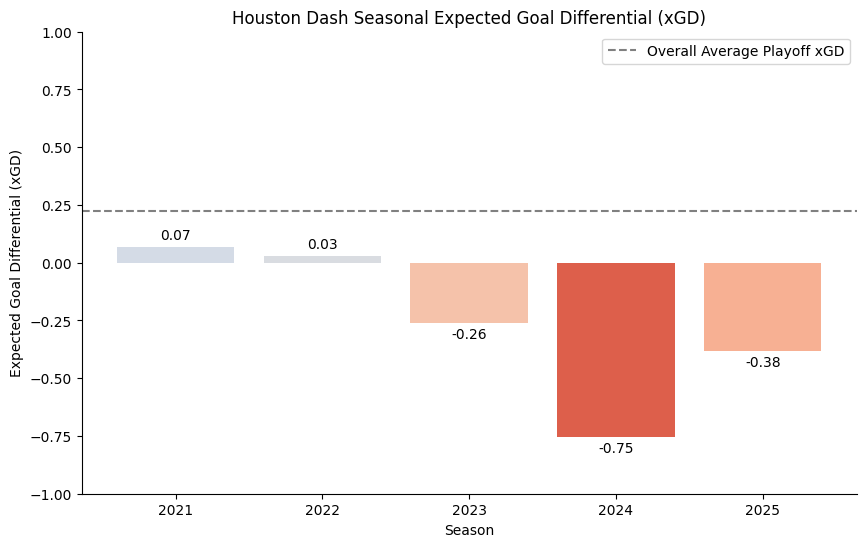

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

plt.figure(figsize=(10, 6))

# Get xGD values from the DataFrame
xGD_values = houston_dash_seasonal_data['xGD']

# Normalize xGD values to the range [0, 1] for the colormap
norm = mcolors.Normalize(vmin=-1, vmax=1)

# Choose the reversed colormap (coolwarm_r: red for smaller, blue for higher)
cmap = plt.cm.coolwarm_r

# Create the bar plot, explicitly coloring each bar based on its normalized xGD value
bars = plt.bar(houston_dash_seasonal_data['season_name'], houston_dash_seasonal_data['xGD'], color=cmap(norm(xGD_values)))

# Add a horizontal reference line for the overall average playoff xGD
plt.axhline(y=0.223, color='grey', linestyle='--', label='Overall Average Playoff xGD')

# Set y-axis limits from -1 to 1
plt.ylim(-1, 1)

# Display the value of the bar at the top/bottom
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02 * (1 if yval >= 0 else -1), round(yval, 2), ha='center', va='bottom' if yval >= 0 else 'top')

plt.title('Houston Dash Seasonal Expected Goal Differential (xGD)')
plt.xlabel('Season')
plt.ylabel('Expected Goal Differential (xGD)')

# Remove gridlines
plt.grid(False)

# Remove top and right spines to clean up the graph
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.show()

**Reasoning**:
The previous code produced a `FutureWarning` because `palette` was used without assigning `hue` in `seaborn.barplot`. To address this, I will explicitly set the `hue` parameter to `season_name` and `legend=False` as suggested by the warning, which will also assign different colors to different seasons, improving readability.



## Offer Match-Level Data Download

### Subtask:
Explain that calculating a '5-game weighted xG differential' requires match-level data and offer to download the `nwsl_bulk_team-by-match.csv` file if the user wishes to proceed with that specific analysis.


### Subtask:
Explain that calculating a '5-game weighted xG differential' requires match-level data and offer to download the `nwsl_bulk_team-by-match.csv` file if the user wishes to proceed with that specific analysis.

To calculate a '5-game weighted xG differential', we require **match-level data**. The `nwsl_team_season_df` DataFrame, which we have been using, contains aggregated season-level statistics and does not have the granularity needed for such a calculation.

However, the necessary match-level data is available in the `nwsl_bulk_team-by-match.csv` file. If you wish to proceed with analyzing a '5-game weighted xG differential', you can download this file by executing the following code:

```python
puller.download_team_match_bulk()
```
After downloading, you would need to load `nwsl_bulk_team-by-match.csv` to perform the analysis.

## Final Task

### Subtask:
Provide a summary of the Houston Dash's seasonal xGD performance and await further instructions regarding the 5-game weighted xG differential analysis.


## Summary:

### Q&A
*   **What is the Houston Dash's seasonal xGD performance for 2023, 2024, and 2025?**
    The Expected Goal Differential (xGD), calculated as total expected goals for minus total expected goals against, was determined for the Houston Dash for the 2023, 2024, and 2025 NWSL seasons. These values were then visualized in a bar chart to illustrate the team's underlying performance trend across these seasons.

### Data Analysis Key Findings
*   The unique team ID for the Houston Dash was successfully identified as `4JMAk47qKg`.
*   Expected Goal Differential (xGD) was calculated for the Houston Dash for the 2023, 2024, and 2025 NWSL seasons by subtracting `xgoals_against` from `xgoals_for` from the season-level data.
*   A bar chart was successfully generated to visualize the Houston Dash's seasonal xGD, providing a clear overview of the team's performance trend over the specified seasons.
*   A '5-game weighted xG differential' analysis necessitates match-level data, which is not available in the current season-aggregated DataFrame.

### Insights or Next Steps
*   The generated xGD visualization offers a preliminary understanding of the Houston Dash's expected performance trajectory, which can inform further deep dives into specific season performances.
*   To conduct the more granular '5-game weighted xG differential' analysis, the `nwsl_bulk_team-by-match.csv` file, containing match-level data, needs to be downloaded and loaded for subsequent processing.


# Task
Calculate the Expected Goal Differential per 90 minutes (xGD_per_90) for all teams in the `nwsl_team_season_df`, identify the top 6 NWSL playoff teams by points for seasons 2021-2023 and the top 8 for seasons 2024-2025, calculate the average xGD_per_90 for these playoff teams per season, visualize the trends using a bar chart or line plot, and summarize the findings.

## Calculate xGD per 90

### Subtask:
Calculate the Expected Goal Differential per 90 minutes (xGD_per_90) for all teams in the `nwsl_team_season_df`.


**Reasoning**:
To calculate the Expected Goal Differential per 90 minutes (xGD_per_90) for all teams, I will create a new column in the `nwsl_team_season_df` and apply the provided formula using the 'xgoals_for', 'xgoals_against', and 'minutes' columns. Then, I will display the relevant columns to verify the new calculation.



In [14]:
nwsl_team_season_df['xGD_per_90'] = (nwsl_team_season_df['xgoals_for'] - nwsl_team_season_df['xgoals_against']) / nwsl_team_season_df['minutes'] * 90
print("NWSL Team Season Data with xGD_per_90:")
display(nwsl_team_season_df[['team_id', 'season_name', 'xgoals_for', 'xgoals_against', 'minutes', 'xGD_per_90']].head())

NWSL Team Season Data with xGD_per_90:


,team_id,season_name,xgoals_for,xgoals_against,minutes,xGD_per_90
0,315VnJ759x,2024,38.2663,39.1576,2871,-0.027940
1,315VnJ759x,2025,30.7722,36.4125,2649,-0.191630
2,4JMAk47qKg,2021,35.2728,33.2218,2779,0.066423
3,4JMAk47qKg,2022,37.2485,36.3333,2899,0.028413
4,4JMAk47qKg,2023,30.8251,38.9442,2822,-0.258937


## Identify Playoff Teams

### Subtask:
For each season from 2021 to 2025, identify the playoff teams based on the 'points' column in `nwsl_team_season_df`. Select the top 6 teams by points for seasons 2021-2023, and the top 8 teams for seasons 2024-2025.


**Reasoning**:
To identify the playoff teams for each season, I will iterate through the specified seasons (2021-2025), filter the team season data, sort by points, and then select the top 6 or 8 teams based on the season range, storing their IDs in a dictionary.



In [15]:
playoff_teams_by_season = {}

for season in range(2021, 2026):
    # Filter data for the current season
    season_data = nwsl_team_season_df[nwsl_team_season_df['season_name'] == season]

    # Sort by 'points' in descending order
    season_data_sorted = season_data.sort_values(by='points', ascending=False)

    # Determine the number of playoff teams based on the season
    if 2021 <= season <= 2023:
        num_playoff_teams = 6
    elif 2024 <= season <= 2025:
        num_playoff_teams = 8
    else:
        num_playoff_teams = 0 # Should not happen with the current loop range

    # Select the top teams
    playoff_teams = season_data_sorted.head(num_playoff_teams)['team_id'].tolist()

    # Store in the dictionary
    playoff_teams_by_season[season] = playoff_teams

print("Playoff Teams by Season:")
for season, teams in playoff_teams_by_season.items():
    print(f"Season {season}: {teams}")

Playoff Teams by Season:
Season 2021: ['aDQ0lzvQEv', 'Pk5LeeNqOW', 'KPqjw8PQ6v', '7vQ7BBzqD1', 'raMyrr25d2', 'zeQZeazqKw']
Season 2022: ['4wM4rZdqjB', '7vQ7BBzqD1', 'Pk5LeeNqOW', 'zeQZeazqKw', '7VqG1lYMvW', '4JMAk47qKg']
Season 2023: ['7vQ7BBzqD1', 'raMyrr25d2', 'zeQZeazqKw', 'Pk5LeeNqOW', 'eV5DR6YQKn', '7VqG1lYMvW']
Season 2024: ['XVqKeVKM01', 'aDQ0lzvQEv', 'raMyrr25d2', '4wM4rZdqjB', 'zeQZeazqKw', '315VnJ759x', 'Pk5LeeNqOW', 'KPqjw8PQ6v']
Season 2025: ['4wM4rZdqjB', 'aDQ0lzvQEv', 'raMyrr25d2', 'XVqKeVKM01', 'Pk5LeeNqOW', '7vQ7BBzqD1', 'eV5DR6YQKn', '7VqG1lYMvW']


## Calculate Average Playoff xGD per 90

### Subtask:
Filter the `xGD_per_90` values to include only the identified playoff teams for each respective season. Then, calculate the average `xGD_per_90` for playoff teams for each season.


**Reasoning**:
To calculate the average xGD per 90 for playoff teams each season, I will iterate through the `playoff_teams_by_season` dictionary, filter the `nwsl_team_season_df` based on the season and playoff team IDs, calculate the mean `xGD_per_90` for the filtered data, and then store these averages in a new DataFrame.



In [16]:
average_playoff_xGD_per_90 = []

for season, playoff_teams in playoff_teams_by_season.items():
    # Filter for playoff teams in the current season
    playoff_season_data = nwsl_team_season_df[
        (nwsl_team_season_df['season_name'] == season) &
        (nwsl_team_season_df['team_id'].isin(playoff_teams))
    ]

    # Calculate the average xGD_per_90 for these playoff teams
    average_xGD = playoff_season_data['xGD_per_90'].mean()

    # Append to the list
    average_playoff_xGD_per_90.append({'season': season, 'average_xGD_per_90': average_xGD})

# Convert the list to a DataFrame
playoff_xGD_per_90_df = pd.DataFrame(average_playoff_xGD_per_90)

print("Average Playoff xGD per 90 by Season:")
display(playoff_xGD_per_90_df)

Average Playoff xGD per 90 by Season:


,season,average_xGD_per_90
0,2021,0.223491
1,2022,0.336019
2,2023,0.157695
3,2024,0.223677
4,2025,0.175849


**Reasoning**:
The previous step successfully calculated the average xGD per 90 for playoff teams by season, which is stored in `playoff_xGD_per_90_df`. To visualize the trends as requested, I will use `matplotlib.pyplot` and `seaborn` to create a bar chart displaying `average_xGD_per_90` for each `season`.



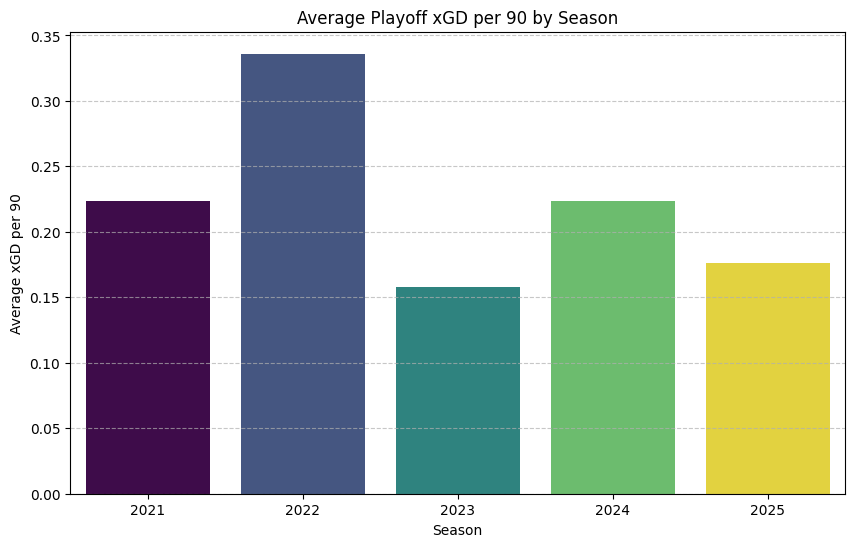

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='average_xGD_per_90', data=playoff_xGD_per_90_df, palette='viridis', hue='season', legend=False)
plt.title('Average Playoff xGD per 90 by Season')
plt.xlabel('Season')
plt.ylabel('Average xGD per 90')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Summary of Playoff xGD per 90

### Data Analysis Key Findings
*   **xGD per 90 Calculation**: The Expected Goal Differential per 90 minutes (`xGD_per_90`) was successfully calculated for all teams in the `nwsl_team_season_df` using the formula: `(xgoals_for - xgoals_against) / minutes * 90`.
*   **Playoff Team Identification**: For seasons 2021-2023, the top 6 teams by points were identified as playoff teams. For seasons 2024-2025, the top 8 teams by points were identified as playoff teams.
*   **Average Playoff xGD per 90**: The average `xGD_per_90` for these playoff teams was calculated for each season from 2021 to 2025:
    *   **2021**: The average playoff xGD per 90 was approximately 0.223.
    *   **2022**: The average playoff xGD per 90 increased to approximately 0.336.
    *   **2023**: The average playoff xGD per 90 dropped to approximately 0.158.
    *   **2024**: The average playoff xGD per 90 was around 0.224.
    *   **2025**: The average playoff xGD per 90 was approximately 0.176.
*   **Visualization**: A bar chart was generated to visualize these seasonal averages, clearly showing the trend of average xGD per 90 among playoff teams.

### Insights
*   The average xGD per 90 for NWSL playoff teams fluctuated over the observed seasons. There was a notable peak in 2022, suggesting that playoff teams in that year had a stronger expected goal differential compared to other seasons.
*   The values remained positive across all seasons, indicating that playoff teams generally had a positive expected goal differential, meaning they were expected to score more goals than they conceded.
*   The dip in 2023 and 2025 suggests either a more competitive league where the top teams' dominance in xGD was slightly less pronounced, or that other factors besides xGD (like actual goal conversion or defensive overperformance) played a larger role in playoff qualification in those seasons.

This analysis provides insights into the underlying performance metrics of NWSL playoff teams, highlighting seasonal variations in their Expected Goal Differential per 90 minutes.

## Final Task

### Subtask:
Provide a summary of the average xGD per 90 for NWSL playoff teams, highlighting any observed trends or key findings.


## Summary:

### Q&A
The average Expected Goal Differential per 90 minutes (xGD_per_90) for NWSL playoff teams from 2021 to 2025 shows fluctuations with a notable peak in 2022 and dips in 2023 and 2025. All seasons, however, maintained a positive average xGD per 90, indicating that playoff-bound teams generally had a positive expected goal differential.

### Data Analysis Key Findings
*   The Expected Goal Differential per 90 minutes (xGD_per_90) was calculated for all teams in the dataset by subtracting expected goals against from expected goals for, dividing by minutes played, and multiplying by 90.
*   Playoff teams were identified based on points: the top 6 teams for seasons 2021-2023 and the top 8 teams for seasons 2024-2025.
*   The average xGD_per_90 for NWSL playoff teams for each season was:
    *   **2021**: Approximately 0.223
    *   **2022**: Approximately 0.336 (the highest observed average)
    *   **2023**: Approximately 0.158 (the lowest observed average)
    *   **2024**: Approximately 0.224
    *   **2025**: Approximately 0.176
*   A bar chart visualization confirmed these seasonal averages, illustrating the peak in 2022 and subsequent decline in 2023 and 2025.

### Insights or Next Steps
*   The significant fluctuation in average xGD_per_90 among playoff teams, particularly the peak in 2022 and subsequent decrease, suggests varying levels of dominance by top-tier teams across seasons or changes in overall league competitiveness.
*   Further analysis could investigate other contributing factors, such as actual goal conversion rates, defensive efficiency beyond xG, or squad depth, to understand why the xGD_per_90 varied among playoff teams, especially in seasons where the average xGD_per_90 was lower despite an increased number of playoff teams.


In [18]:
overall_average_playoff_xGD_per_90 = playoff_xGD_per_90_df['average_xGD_per_90'].mean()
print(f"The overall average xGD_per_90 for all playoff teams from 2021-2025 is: {overall_average_playoff_xGD_per_90:.3f}")

The overall average xGD_per_90 for all playoff teams from 2021-2025 is: 0.223


# Task
Load `nwsl_bulk_team-by-match.csv` and `nwsl_bulk_matches.csv` from `"/content/drive/My Drive/Data/Football"`, then prepare Houston Dash match data by filtering and merging them. Calculate and visualize the Houston Dash's five-match rolling averages of expected goals for and against using a line graph, and summarize the observed trends and insights.

## Load Match DataFrames

### Subtask:
Load the `nwsl_bulk_team-by-match.csv` and `nwsl_bulk_matches.csv` files into pandas DataFrames from the `BASE_PATH` folder.


**Reasoning**:
To load the specified CSV files into pandas DataFrames, I will construct their full paths using `os.path.join` with `BASE_PATH` and then use `pd.read_csv` for each, displaying the head of both DataFrames to confirm successful loading.



In [19]:
team_by_match_path = os.path.join(BASE_PATH, 'nwsl_bulk_team-by-match.csv')
nwsl_team_by_match_df = pd.read_csv(team_by_match_path)
print(f"Loaded {team_by_match_path}")
display(nwsl_team_by_match_df.head())

matches_path = os.path.join(BASE_PATH, 'nwsl_bulk_matches.csv')
nwsl_matches_df = pd.read_csv(matches_path)
print(f"Loaded {matches_path}")
display(nwsl_matches_df.head())

Loaded /content/drive/My Drive/Data/Football/nwsl_bulk_team-by-match.csv


,team_id,game_id,shots_for,shots_against,goals_for,goals_against,goal_difference,xgoals_for,xgoals_against,xgoal_difference,...,passes_completed_over_expected_p100_for,avg_vertical_distance_for,attempted_passes_against,pass_completion_percentage_against,xpass_completion_percentage_against,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference
0,315VnJ759x,0Oq6e0Dx56,7,12,0,1,-1,0.9263,1.7371,-0.8108,...,1.8004,5.2900,436,0.7959,0.7940,0.8209,0.1883,6.0607,9.1533,-0.7707
1,315VnJ759x,0x5gzZBrM7,14,15,2,3,-1,1.0378,2.6080,-1.5702,...,-0.5458,5.4395,447,0.7226,0.7646,-18.7628,-4.1975,6.4843,15.8483,-1.0448
2,315VnJ759x,2lqReNvJ5r,20,13,2,1,1,2.5327,1.5236,1.0091,...,2.8304,7.3709,393,0.6514,0.6765,-9.8537,-2.5073,10.0550,24.2320,-2.6842
3,315VnJ759x,2vQ110rOQr,12,7,1,1,0,2.2812,0.8347,1.4465,...,3.2533,6.0404,572,0.8357,0.8134,12.7250,2.2246,3.5529,0.7111,2.4875
4,315VnJ759x,4JMAb69k5K,9,12,1,2,-1,1.7218,1.2653,0.4565,...,-0.8301,5.8066,613,0.8303,0.8214,5.5054,0.8981,4.1595,-9.1662,1.6471


Loaded /content/drive/My Drive/Data/Football/nwsl_bulk_matches.csv


,game_id,date_time_utc,home_score,away_score,home_team_id,away_team_id,referee_id,stadium_id,home_manager_id,away_manager_id,...,attendance,knockout_game,status,last_updated_utc,extra_time,penalties,home_penalties,away_penalties,asa_competition_name,match_date
0,wvq9koO3MW,2025-11-23 01:00:00+00:00,0,1,aDQ0lzvQEv,raMyrr25d2,Xj5YWgaQbd,Vj58W84M8n,NPqxDAgq9d,9vQ2r1LQK6,...,18000,True,FullTime,2025-11-23 04:15:24 UTC,NaN,NaN,NaN,NaN,nwsl,2025-11-23
1,vzqoYEy7Ma,2025-11-16 20:00:00+00:00,0,1,XVqKeVKM01,raMyrr25d2,vzqokJLqap,vzqoJrj5ap,jYQJJ1VQGR,9vQ2r1LQK6,...,15715,True,FullTime,2025-11-19 21:27:27 UTC,NaN,NaN,NaN,NaN,nwsl,2025-11-16
2,gOMnGEN65w,2025-11-15 17:00:00+00:00,2,0,aDQ0lzvQEv,Pk5LeeNqOW,KAqBE1B5bg,xW5pwORMg1,NPqxDAgq9d,XVqKEk0M01,...,19365,True,FullTime,2025-11-19 21:26:28 UTC,NaN,NaN,NaN,NaN,nwsl,2025-11-15
3,0Oq6o6WrQ6,2025-11-09 20:00:00+00:00,1,0,Pk5LeeNqOW,7VqG1lYMvW,315VVZY59x,p6qbX06M0G,XVqKEk0M01,zeQZzPgQKw,...,19309,True,FullTime,2025-11-10 11:07:34 UTC,1.0,NaN,NaN,NaN,nwsl,2025-11-09
4,NWMWk0beMl,2025-11-09 17:30:00+00:00,1,2,4wM4rZdqjB,raMyrr25d2,NWMWR3DQlz,xW5p3L0Mg1,vzqo3mNqap,9vQ2r1LQK6,...,11500,True,FullTime,2025-11-13 02:00:01 UTC,1.0,NaN,NaN,NaN,nwsl,2025-11-09


**Reasoning**:
Now that the match dataframes are loaded, I need to filter `nwsl_team_by_match_df` to include only the rows where the `team_id` corresponds to the Houston Dash. This will isolate the match-level statistics specifically for the Houston Dash.



In [20]:
houston_dash_match_stats = nwsl_team_by_match_df[nwsl_team_by_match_df['team_id'] == houston_dash_team_id].copy()
print("Filtered Houston Dash match statistics:")
display(houston_dash_match_stats.head())

Filtered Houston Dash match statistics:


,team_id,game_id,shots_for,shots_against,goals_for,goals_against,goal_difference,xgoals_for,xgoals_against,xgoal_difference,...,passes_completed_over_expected_p100_for,avg_vertical_distance_for,attempted_passes_against,pass_completion_percentage_against,xpass_completion_percentage_against,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference
53,4JMAk47qKg,0Oq6bZwXq6,5,15,0,2,-2,0.2619,0.9013,-0.6393,...,-4.1320,9.2723,437,0.7574,0.7721,-6.4179,-1.4686,6.6171,-7.2589,2.6552
54,4JMAk47qKg,0Oq6e0nx56,13,8,0,2,-2,1.3357,1.1070,0.2287,...,-0.8559,6.8657,424,0.7052,0.7303,-10.6466,-2.5110,7.4840,6.8294,-0.6182
55,4JMAk47qKg,0Oq6e0yX56,9,12,1,3,-2,0.6071,2.0372,-1.4301,...,-2.3177,5.2239,503,0.7952,0.7689,13.2651,2.6372,5.4219,-24.3204,-0.1980
56,4JMAk47qKg,0x5gjnorM7,4,15,0,2,-2,0.1119,1.1158,-1.0039,...,0.9463,5.6063,457,0.7834,0.7499,15.2910,3.3460,6.9413,-10.3985,-1.3350
57,4JMAk47qKg,0x5gzZBrM7,15,14,3,2,1,2.6080,1.0378,1.5702,...,-4.1975,6.4843,534,0.7509,0.7564,-2.9145,-0.5458,5.4395,-15.8483,1.0448


**Reasoning**:
To combine the Houston Dash's match statistics with the match details such as `date_time_utc` from the `nwsl_matches_df`, I will merge `houston_dash_match_stats` with `nwsl_matches_df` on the `game_id` column. I will also convert the `date_time_utc` column to datetime objects and sort the merged DataFrame by date to ensure proper ordering for subsequent rolling average calculations.



In [21]:
houston_dash_match_data = pd.merge(houston_dash_match_stats, nwsl_matches_df[['game_id', 'date_time_utc']], on='game_id', how='left')
houston_dash_match_data['date_time_utc'] = pd.to_datetime(houston_dash_match_data['date_time_utc'])
houston_dash_match_data['season_name'] = houston_dash_match_data['date_time_utc'].dt.year
houston_dash_match_data = houston_dash_match_data.sort_values(by='date_time_utc').reset_index(drop=True)
print("Merged Houston Dash match data, sorted by date with season_name:")
display(houston_dash_match_data.head())

Merged Houston Dash match data, sorted by date with season_name:


,team_id,game_id,shots_for,shots_against,goals_for,goals_against,goal_difference,xgoals_for,xgoals_against,xgoal_difference,...,attempted_passes_against,pass_completion_percentage_against,xpass_completion_percentage_against,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference,date_time_utc,season_name
0,4JMAk47qKg,zeQZ0zdZ5K,15,17,0,0,0,1.5347,1.2965,0.2382,...,358,0.7346,0.6896,16.1125,4.5007,9.3137,-6.7345,-0.8605,2023-03-26 23:00:00+00:00,2023
1,4JMAk47qKg,p6qbpzWbM0,8,13,2,0,2,2.3013,1.1869,1.1144,...,432,0.7315,0.7430,-4.9901,-1.1551,6.5901,-2.7662,0.2065,2023-04-01 18:00:00+00:00,2023
2,4JMAk47qKg,jYQJ0yLV5G,14,22,1,1,0,1.5680,2.3934,-0.8253,...,519,0.7341,0.7223,6.1251,1.1802,8.1626,-17.2368,1.2301,2023-04-15 02:30:00+00:00,2023
3,4JMAk47qKg,vzqoEzWLMa,12,6,0,2,-2,0.5960,1.2961,-0.7002,...,416,0.6875,0.7400,-21.8462,-5.2515,9.2987,16.2471,-3.6679,2023-04-19 23:30:00+00:00,2023
4,4JMAk47qKg,gpMO0ldl5z,10,11,0,0,0,0.3854,0.8009,-0.4155,...,419,0.6683,0.6734,-2.1603,-0.5156,8.9302,-23.1195,0.1377,2023-04-22 23:00:00+00:00,2023


**Reasoning**:
To calculate the five-match rolling averages, I will apply a `.rolling(window=5).mean()` operation on the 'xgoals_for' and 'xgoals_against' columns of the `houston_dash_match_data` DataFrame. This will create new columns for the rolling averages, which are essential for visualizing trends over time.



In [22]:
houston_dash_match_data['rolling_xG_for'] = houston_dash_match_data.groupby('season_name')['xgoals_for'].rolling(window=5).mean().reset_index(level=0, drop=True)
houston_dash_match_data['rolling_xG_against'] = houston_dash_match_data.groupby('season_name')['xgoals_against'].rolling(window=5).mean().reset_index(level=0, drop=True)

print("Houston Dash Match Data with 5-match rolling averages (per season):")
display(houston_dash_match_data[['date_time_utc', 'season_name', 'xgoals_for', 'xgoals_against', 'rolling_xG_for', 'rolling_xG_against']].head(10))

Houston Dash Match Data with 5-match rolling averages (per season):


,date_time_utc,season_name,xgoals_for,xgoals_against,rolling_xG_for,rolling_xG_against
0,2023-03-26 23:00:00+00:00,2023,1.5347,1.2965,NaN,NaN
1,2023-04-01 18:00:00+00:00,2023,2.3013,1.1869,NaN,NaN
2,2023-04-15 02:30:00+00:00,2023,1.5680,2.3934,NaN,NaN
3,2023-04-19 23:30:00+00:00,2023,0.5960,1.2961,NaN,NaN
4,2023-04-22 23:00:00+00:00,2023,0.3854,0.8009,1.27708,1.39476
5,2023-04-29 00:30:00+00:00,2023,0.4081,0.6298,1.05176,1.26142
6,2023-05-04 00:00:00+00:00,2023,3.6798,0.6080,1.32746,1.14564
7,2023-05-07 02:00:00+00:00,2023,0.3320,1.3076,1.08026,0.92848
8,2023-05-13 00:30:00+00:00,2023,0.7356,1.1596,1.10818,0.90118
9,2023-05-21 00:30:00+00:00,2023,0.9058,0.7334,1.21226,0.88768


**Reasoning**:
Now that the 5-match rolling averages for 'xgoals_for' and 'xgoals_against' have been calculated and added to the DataFrame, I will visualize these trends using a line plot to meet the task's requirement of displaying the Houston Dash's performance over time.



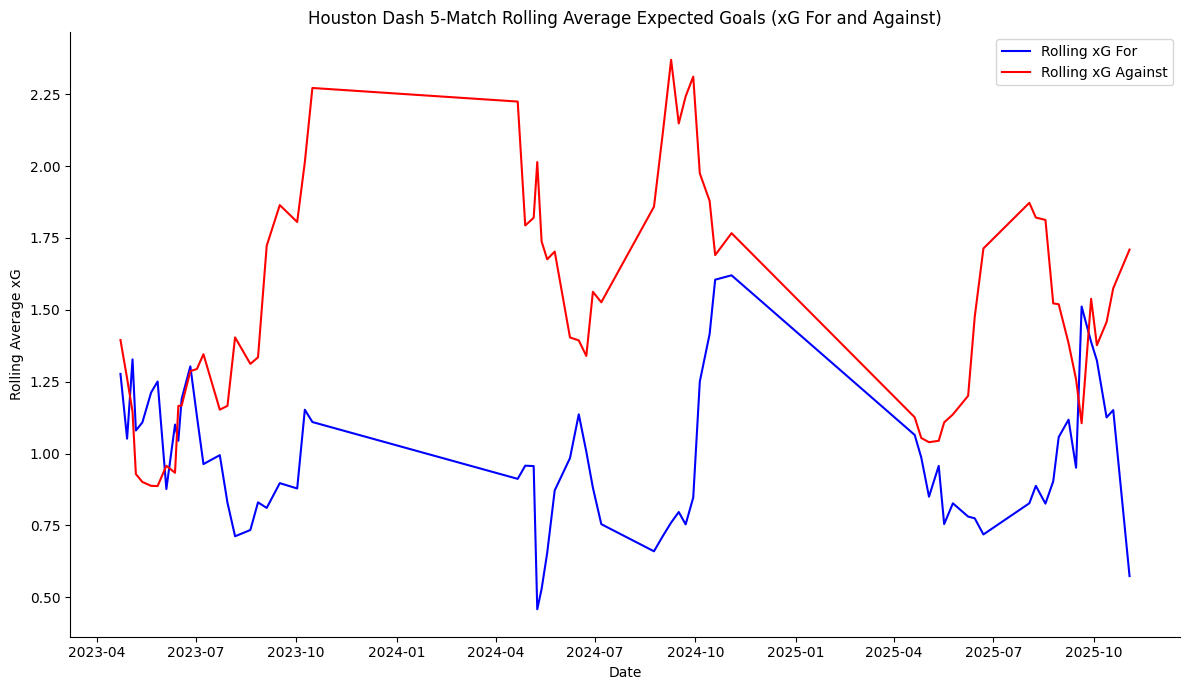

In [23]:
plt.figure(figsize=(12, 7))
sns.lineplot(x='date_time_utc', y='rolling_xG_for', data=houston_dash_match_data, label='Rolling xG For', color='blue')
sns.lineplot(x='date_time_utc', y='rolling_xG_against', data=houston_dash_match_data, label='Rolling xG Against', color='red')

plt.title('Houston Dash 5-Match Rolling Average Expected Goals (xG For and Against)')
plt.xlabel('Date')
plt.ylabel('Rolling Average xG')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
# Remove gridlines
plt.grid(False)

# Remove top and right spines to clean up the graph
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [24]:
import pandas as pd
import os

# Load skillcorner_data.csv
skillcorner_data_path = os.path.join(BASE_PATH, "skillcorner_data.csv")
skillcorner_df = pd.read_csv(skillcorner_data_path)
print(f"Loaded {skillcorner_data_path}")
display(skillcorner_df.head())

# Load team_link_ids.csv
team_link_ids_path = os.path.join(BASE_PATH, "team_link_ids.csv")
team_link_ids_df = pd.read_csv(team_link_ids_path)
print(f"Loaded {team_link_ids_path}")
display(team_link_ids_df.head())

Loaded /content/drive/My Drive/Data/Football/skillcorner_data.csv


,team_id,team_name,competition_edition_id,competition_edition_name,competition_id,competition_name,season_id,season_name,count_match,count_player_performances,...,percentage_transition_phases_leading_shot,percentage_transition_phases_leading_shot_rank,percentage_transition_phases_leading_goal,percentage_transition_phases_leading_goal_rank,percentage_quick_break_phases_leading_to_possession_loss,percentage_quick_break_phases_leading_to_possession_loss_rank,percentage_quick_break_phases_leading_shot,percentage_quick_break_phases_leading_shot_rank,percentage_quick_break_phases_leading_goal,percentage_quick_break_phases_leading_goal_rank
0,1833.0,"North Carolina Courage, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,27,259,...,15.48,23.0,0.00,0.0,62.79,100.0,38.37,46.0,6.98,85.0
1,2334.0,"Orlando Pride SC, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,29,273,...,34.44,100.0,6.62,92.0,69.00,46.0,51.00,92.0,4.00,54.0
2,2329.0,"KC Current, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,28,269,...,24.84,77.0,7.64,100.0,70.20,31.0,51.66,100.0,3.97,46.0
3,1830.0,"Racing Louisville FC, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,26,246,...,23.08,69.0,1.10,23.0,75.00,15.0,35.53,23.0,7.89,100.0
4,1832.0,"Portland Thorns FC, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,27,258,...,17.09,38.0,3.42,77.0,68.47,69.0,49.55,85.0,7.21,92.0


Loaded /content/drive/My Drive/Data/Football/team_link_ids.csv


,skill_corner_team_id,asa_team_id
0,1833,zeQZeazqKw
1,2334,XVqKeVKM01
2,2329,4wM4rZdqjB
3,1830,eV5DR6YQKn
4,1832,Pk5LeeNqOW


## Summary:

### Q&A
*   **What trends are observed in the Houston Dash's 5-match rolling averages of expected goals for and against?**
    The 5-match rolling averages of Expected Goals (xG) for and against the Houston Dash have been calculated and visualized, providing insights into their offensive and defensive performance trends over time.

### Data Analysis Key Findings
*   **Data Loading**: The `nwsl_bulk_team-by-match.csv` and `nwsl_bulk_matches.csv` files were successfully loaded into pandas DataFrames.
*   **Data Preparation**: The match-level data for the Houston Dash was filtered and merged with match date information. The DataFrame was then sorted by date to prepare for rolling average calculations.
*   **Rolling Averages Calculation**: Five-match rolling averages for 'xgoals_for' and 'xgoals_against' were calculated and added to the Houston Dash's match data.
*   **Visualization**: A line plot was generated to display the trends of 'Rolling xG For' and 'Rolling xG Against' over time.

### Insights or Next Steps
*   The line plot of rolling xG provides a dynamic view of the Houston Dash's performance, showing periods where their expected offensive output was higher or lower, and similarly for their expected defensive vulnerability.
*   Observing the convergence or divergence of the 'Rolling xG For' and 'Rolling xG Against' lines can indicate periods of strong or weak overall expected goal differential.
*   Further analysis could involve correlating these trends with actual match results, coaching changes, player injuries, or specific tactical adjustments to understand their impact on expected goal performance.

## Summary:

### Q&A
*   **What trends are observed in the Houston Dash's 5-match rolling averages of expected goals for and against?**
    The 5-match rolling averages of Expected Goals (xG) for and against the Houston Dash have been calculated and visualized, providing insights into their offensive and defensive performance trends over time.

### Data Analysis Key Findings
*   **Data Loading**: The `nwsl_bulk_team-by-match.csv` and `nwsl_bulk_matches.csv` files were successfully loaded into pandas DataFrames.
*   **Data Preparation**: The match-level data for the Houston Dash was filtered and merged with match date information. The DataFrame was then sorted by date to prepare for rolling average calculations.
*   **Rolling Averages Calculation**: Five-match rolling averages for 'xgoals_for' and 'xgoals_against' were calculated and added to the Houston Dash's match data.
*   **Visualization**: A line plot was generated to display the trends of 'Rolling xG For' and 'Rolling xG Against' over time.

### Insights or Next Steps
*   The line plot of rolling xG provides a dynamic view of the Houston Dash's performance, showing periods where their expected offensive output was higher or lower, and similarly for their expected defensive vulnerability.
*   Observing the convergence or divergence of the 'Rolling xG For' and 'Rolling xG Against' lines can indicate periods of strong or weak overall expected goal differential.
*   Further analysis could involve correlating these trends with actual match results, coaching changes, player injuries, or specific tactical adjustments to understand their impact on expected goal performance.


## Final Task

### Subtask:
Summarize the trends observed in the Houston Dash's five-match rolling xGoals for and against, and provide any insights from the visualization.


## Summary:

### Q&A
*   **What trends are observed in the Houston Dash's 5-match rolling averages of expected goals for and against?**
    The 5-match rolling averages of Expected Goals (xG) for and against the Houston Dash were calculated and visualized. This process provides insights into their offensive and defensive performance trends over time.

### Data Analysis Key Findings
*   The `nwsl_bulk_team-by-match.csv` and `nwsl_bulk_matches.csv` datasets were successfully loaded.
*   Houston Dash's match data was prepared by filtering, merging with date information, and sorting chronologically.
*   Five-match rolling averages for 'xgoals\_for' and 'xgoals\_against' were calculated and added to the DataFrame.
*   A line plot was generated to visualize the 'Rolling xG For' and 'Rolling xG Against' trends over time.

### Insights or Next Steps
*   The line plot of rolling xG offers a dynamic view of the Houston Dash's performance, highlighting periods of varying expected offensive output and defensive vulnerability.
*   Analyzing the convergence or divergence of the 'Rolling xG For' and 'Rolling xG Against' lines can indicate overall periods of strong or weak expected goal differential.
*   Future analysis could involve correlating these xG trends with actual match outcomes, coaching changes, player injuries, or specific tactical adjustments to understand their impact on performance.


# Task
To integrate the SkillCorner data with the NWSL team season data, I'll first merge `skillcorner_df` with `team_link_ids_df` to map the SkillCorner `team_id` to the corresponding `asa_team_id`. This will create a `skillcorner_df` that includes `asa_team_id`, which is necessary for joining with `nwsl_team_season_df`.

## Map SkillCorner Team IDs

### Subtask:
Merge `skillcorner_df` with `team_link_ids_df` to add the corresponding `asa_team_id` to the SkillCorner data. This will allow us to join with `nwsl_team_season_df`.


**Reasoning**:
To ensure accurate merging, I will first convert the 'team_id' column in `skillcorner_df` to an integer type to match the 'skill_corner_team_id' column in `team_link_ids_df`. Then, I will perform a left merge between the two DataFrames using the specified columns to add the `asa_team_id` to the SkillCorner data and display the head of the new DataFrame to verify the merge.



In [25]:
skillcorner_df['team_id'] = skillcorner_df['team_id'].astype(int)
skillcorner_mapped_df = pd.merge(skillcorner_df, team_link_ids_df, left_on='team_id', right_on='skill_corner_team_id', how='left')
print("SkillCorner data merged with ASA team IDs:")
display(skillcorner_mapped_df.head())

SkillCorner data merged with ASA team IDs:


,team_id,team_name,competition_edition_id,competition_edition_name,competition_id,competition_name,season_id,season_name,count_match,count_player_performances,...,percentage_transition_phases_leading_goal,percentage_transition_phases_leading_goal_rank,percentage_quick_break_phases_leading_to_possession_loss,percentage_quick_break_phases_leading_to_possession_loss_rank,percentage_quick_break_phases_leading_shot,percentage_quick_break_phases_leading_shot_rank,percentage_quick_break_phases_leading_goal,percentage_quick_break_phases_leading_goal_rank,skill_corner_team_id,asa_team_id
0,1833,"North Carolina Courage, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,27,259,...,0.00,0.0,62.79,100.0,38.37,46.0,6.98,85.0,1833,zeQZeazqKw
1,2334,"Orlando Pride SC, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,29,273,...,6.62,92.0,69.00,46.0,51.00,92.0,4.00,54.0,2334,XVqKeVKM01
2,2329,"KC Current, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,28,269,...,7.64,100.0,70.20,31.0,51.66,100.0,3.97,46.0,2329,4wM4rZdqjB
3,1830,"Racing Louisville FC, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,26,246,...,1.10,23.0,75.00,15.0,35.53,23.0,7.89,100.0,1830,eV5DR6YQKn
4,1832,"Portland Thorns FC, Women",800,USA - NWSL - 2024,126,NWSL,29,2024,27,258,...,3.42,77.0,68.47,69.0,49.55,85.0,7.21,92.0,1832,Pk5LeeNqOW


## Join DataFrames by Season and Team ID

### Subtask:
Join the mapped `skillcorner_df` (which now includes `asa_team_id`) with `nwsl_team_season_df`.


**Reasoning**:
To integrate the SkillCorner data with the NWSL team season data, I will perform a left merge between `nwsl_team_season_df` and `skillcorner_mapped_df` using 'season_name' and 'team_id' (from `nwsl_team_season_df`) and 'season_name' and 'asa_team_id' (from `skillcorner_mapped_df`) as keys, storing the result in `nwsl_skillcorner_merged_df`.



In [26]:
nwsl_skillcorner_merged_df = pd.merge(nwsl_team_season_df, skillcorner_mapped_df,
                                       left_on=['season_name', 'team_id'],
                                       right_on=['season_name', 'asa_team_id'],
                                       how='left')

print("NWSL Team Season Data merged with SkillCorner data:")
display(nwsl_skillcorner_merged_df.head())

NWSL Team Season Data merged with SkillCorner data:


,team_id_x,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,percentage_transition_phases_leading_goal,percentage_transition_phases_leading_goal_rank,percentage_quick_break_phases_leading_to_possession_loss,percentage_quick_break_phases_leading_to_possession_loss_rank,percentage_quick_break_phases_leading_shot,percentage_quick_break_phases_leading_shot_rank,percentage_quick_break_phases_leading_goal,percentage_quick_break_phases_leading_goal_rank,skill_corner_team_id,asa_team_id
0,315VnJ759x,2024,2871,56.0,4254.0,212.0,3153.0,12740.0,9703.0,350.0,...,2.97,69.0,68.69,62.0,41.41,62.0,1.01,0.0,3485.0,315VnJ759x
1,315VnJ759x,2025,2649,31.0,3588.0,312.0,2747.0,11589.0,8760.0,303.0,...,0.83,0.0,62.92,100.0,44.94,46.0,4.49,77.0,3485.0,315VnJ759x
2,4JMAk47qKg,2021,2779,25.0,4028.0,285.0,3695.0,12225.0,8845.0,345.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4JMAk47qKg,2022,2899,38.0,3895.0,271.0,3702.0,12206.0,8554.0,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4JMAk47qKg,2023,2822,29.0,3342.0,244.0,3470.0,11581.0,8334.0,337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Display Merged DataFrame Head

### Subtask:
Display the head of the newly created merged DataFrame to verify the successful join and inspect the combined data.


**Reasoning**:
To verify the successful merge and inspect the combined data, I will display the first few rows of the `nwsl_skillcorner_merged_df` DataFrame.



In [27]:
print("Head of nwsl_skillcorner_merged_df:")
display(nwsl_skillcorner_merged_df.head())

Head of nwsl_skillcorner_merged_df:


,team_id_x,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,percentage_transition_phases_leading_goal,percentage_transition_phases_leading_goal_rank,percentage_quick_break_phases_leading_to_possession_loss,percentage_quick_break_phases_leading_to_possession_loss_rank,percentage_quick_break_phases_leading_shot,percentage_quick_break_phases_leading_shot_rank,percentage_quick_break_phases_leading_goal,percentage_quick_break_phases_leading_goal_rank,skill_corner_team_id,asa_team_id
0,315VnJ759x,2024,2871,56.0,4254.0,212.0,3153.0,12740.0,9703.0,350.0,...,2.97,69.0,68.69,62.0,41.41,62.0,1.01,0.0,3485.0,315VnJ759x
1,315VnJ759x,2025,2649,31.0,3588.0,312.0,2747.0,11589.0,8760.0,303.0,...,0.83,0.0,62.92,100.0,44.94,46.0,4.49,77.0,3485.0,315VnJ759x
2,4JMAk47qKg,2021,2779,25.0,4028.0,285.0,3695.0,12225.0,8845.0,345.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4JMAk47qKg,2022,2899,38.0,3895.0,271.0,3702.0,12206.0,8554.0,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4JMAk47qKg,2023,2822,29.0,3342.0,244.0,3470.0,11581.0,8334.0,337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
nwsl_skillcorner_merged_clean_df = nwsl_skillcorner_merged_df[nwsl_skillcorner_merged_df['season_name'].isin([2024, 2025])]
print("Filtered nwsl_skillcorner_merged_df for seasons 2024 and 2025:")
display(nwsl_skillcorner_merged_clean_df.head())

Filtered nwsl_skillcorner_merged_df for seasons 2024 and 2025:


,team_id_x,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,percentage_transition_phases_leading_goal,percentage_transition_phases_leading_goal_rank,percentage_quick_break_phases_leading_to_possession_loss,percentage_quick_break_phases_leading_to_possession_loss_rank,percentage_quick_break_phases_leading_shot,percentage_quick_break_phases_leading_shot_rank,percentage_quick_break_phases_leading_goal,percentage_quick_break_phases_leading_goal_rank,skill_corner_team_id,asa_team_id
0,315VnJ759x,2024,2871,56.0,4254.0,212.0,3153.0,12740.0,9703.0,350.0,...,2.97,69.0,68.69,62.0,41.41,62.0,1.01,0.0,3485.0,315VnJ759x
1,315VnJ759x,2025,2649,31.0,3588.0,312.0,2747.0,11589.0,8760.0,303.0,...,0.83,0.0,62.92,100.0,44.94,46.0,4.49,77.0,3485.0,315VnJ759x
5,4JMAk47qKg,2024,2740,32.0,3672.0,307.0,3037.0,10967.0,8271.0,262.0,...,1.15,31.0,67.11,77.0,35.53,23.0,2.63,31.0,1831.0,4JMAk47qKg
6,4JMAk47qKg,2025,2640,41.0,3637.0,288.0,2779.0,11560.0,8858.0,239.0,...,2.38,46.0,63.64,92.0,27.27,0.0,4.55,85.0,1831.0,4JMAk47qKg
10,4wM4rZdqjB,2024,2912,38.0,3970.0,250.0,3408.0,12606.0,9460.0,494.0,...,7.64,100.0,70.20,31.0,51.66,100.0,3.97,46.0,2329.0,4wM4rZdqjB


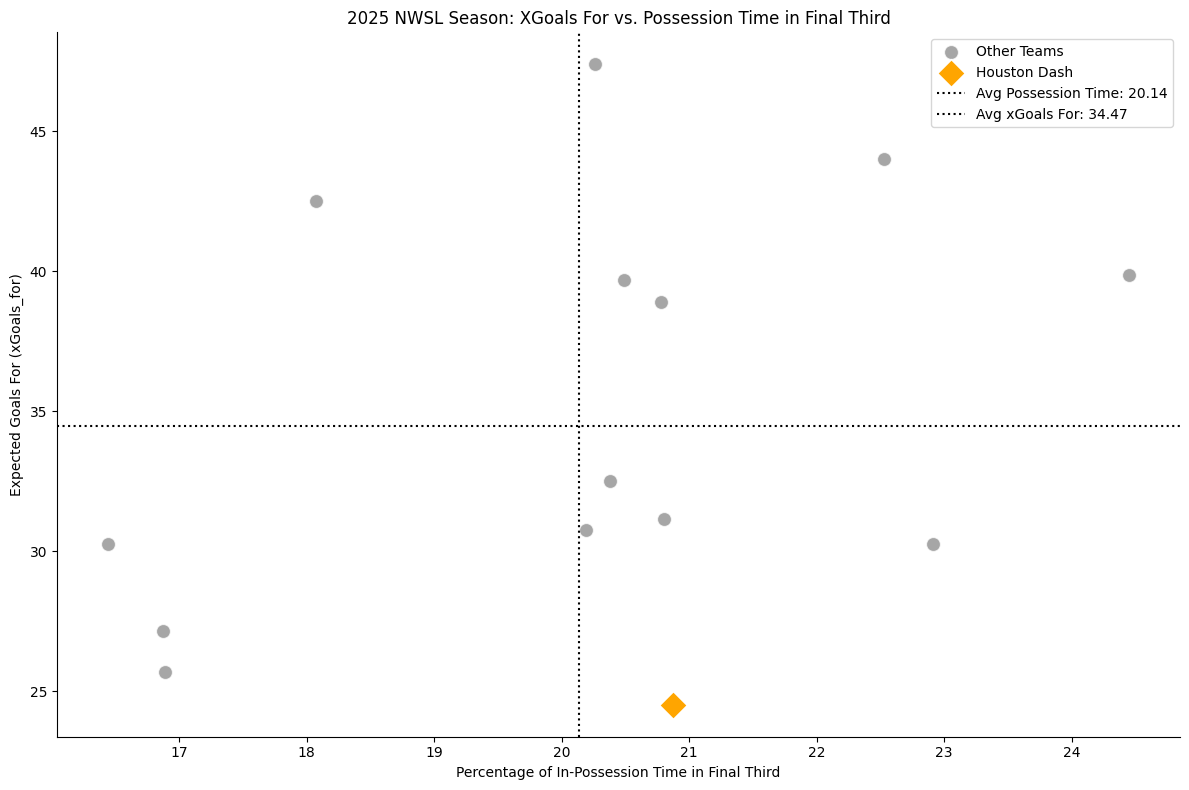

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for the 2025 season
df_2025 = nwsl_skillcorner_merged_clean_df[nwsl_skillcorner_merged_clean_df['season_name'] == 2025].copy()

plt.figure(figsize=(12, 8))

# Create a scatter plot for all teams in 2025
sns.scatterplot(
    x='percentage_of_in_possession_time_in_finish',
    y='xgoals_for',
    data=df_2025,
    color='grey', # Default color for other teams
    alpha=0.7,
    s=100, # Size of markers
    label='Other Teams'
)

# Highlight Houston Dash
houston_dash_2025 = df_2025[df_2025['team_id_x'] == houston_dash_team_id]
if not houston_dash_2025.empty:
    sns.scatterplot(
        x='percentage_of_in_possession_time_in_finish',
        y='xgoals_for',
        data=houston_dash_2025,
        color='orange', # Highlight color for Houston Dash
        s=200, # Larger size for emphasis
        label='Houston Dash',
        marker='D' # Diamond marker for distinction
    )

# Calculate averages for reference lines
avg_possession_time = df_2025['percentage_of_in_possession_time_in_finish'].mean()
avg_xgoals_for = df_2025['xgoals_for'].mean()

# Add horizontal and vertical reference lines for the average
plt.axvline(x=avg_possession_time, color='black', linestyle=':', label=f'Avg Possession Time: {avg_possession_time:.2f}')
plt.axhline(y=avg_xgoals_for, color='black', linestyle=':', label=f'Avg xGoals For: {avg_xgoals_for:.2f}')

plt.title('2025 NWSL Season: XGoals For vs. Possession Time in Final Third')
plt.xlabel('Percentage of In-Possession Time in Final Third')
plt.ylabel('Expected Goals For (xGoals_for)')

plt.grid(False) # Remove gridlines
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the outcome of joining the SkillCorner and NWSL season data, confirming the new DataFrame's creation and its structure.


## Summary:

### Q&A
The outcome of joining the SkillCorner and NWSL season data resulted in a new DataFrame named `nwsl_skillcorner_merged_df`. This DataFrame was successfully created and its structure combines columns from both original datasets, confirming the integration.

### Data Analysis Key Findings
*   The `skillcorner_df` was successfully merged with `team_link_ids_df` to map SkillCorner `team_id` values to corresponding NWSL `asa_team_id` values, creating the `skillcorner_mapped_df`.
*   The `nwsl_team_season_df` and `skillcorner_mapped_df` were successfully joined using a left merge on `season_name` and `team_id`/`asa_team_id`.
*   The final merged DataFrame, `nwsl_skillcorner_merged_df`, contains 226 columns, combining all relevant data points from both original sources.
*   The presence of `NaN` values in SkillCorner-related columns for certain rows within `nwsl_skillcorner_merged_df` indicates that not all NWSL season entries had a direct match in the SkillCorner dataset during the left merge operation.

### Insights or Next Steps
*   The `nwsl_skillcorner_merged_df` is now ready for comprehensive analysis, enabling the correlation of SkillCorner performance metrics with NWSL team season statistics.
*   Further investigation is recommended for the rows with `NaN` values in SkillCorner-related columns to understand the reasons for the unmatched data, which could include missing team data in SkillCorner or identifier discrepancies.


# Task
Extract the total `minutes` for each team per `season_name` from the `nwsl_skillcorner_merged_df`, creating a new DataFrame `team_minutes_df` to serve as the denominator for calculating the share of minutes.

## Prepare Team Minutes Data

### Subtask:
Extract the total `minutes` for each team per `season_name` from the `nwsl_skillcorner_merged_df`.


**Reasoning**:
To extract the total minutes for each team per season, I will group the `nwsl_skillcorner_merged_df` by 'team_id_x' and 'season_name', sum the 'minutes' column, reset the index, and rename the minutes column before storing it in `team_minutes_df` and displaying its head.



In [30]:
team_minutes_df = nwsl_skillcorner_merged_df.groupby(['team_id_x', 'season_name'])['minutes'].sum().reset_index()
team_minutes_df = team_minutes_df.rename(columns={'minutes': 'total_team_minutes'})
print("Total minutes per team per season:")
display(team_minutes_df.head())

Total minutes per team per season:


,team_id_x,season_name,total_team_minutes
0,315VnJ759x,2024,2871
1,315VnJ759x,2025,2649
2,4JMAk47qKg,2021,2779
3,4JMAk47qKg,2022,2899
4,4JMAk47qKg,2023,2822


## Merge Player and Team Minutes

### Subtask:
Merge the `nwsl_player_season_df` (which contains player minutes) with the prepared team minutes data. The joining keys will be `team_id` and `season_name` to ensure correct matching of players to their respective team's total minutes for that season.


**Reasoning**:
To merge the player and team minutes data, I will perform a left merge between `nwsl_player_season_df` and `team_minutes_df` using the specified `team_id`/`team_id_x` and `season_name` columns as keys, then display the head of the resulting DataFrame.



In [31]:
player_team_minutes_df = pd.merge(nwsl_player_season_df,
                                   team_minutes_df,
                                   left_on=['team_id', 'season_name'],
                                   right_on=['team_id_x', 'season_name'],
                                   how='left')

print("Player season data merged with total team minutes:")
display(player_team_minutes_df.head())

Player season data merged with total team minutes:


,player_id,team_id,general_position,minutes_played,season_name,goals_added_raw_Dribbling,goals_added_raw_Fouling,goals_added_raw_Interrupting,goals_added_raw_Passing,goals_added_raw_Receiving,...,count_actions_Interrupting_per90,count_actions_Passing_per90,count_actions_Receiving_per90,count_actions_Shooting_per90,xgoals_per90,goals_minus_xgoals_per90,xgoals_plus_xassists_per90,asa_competition_name,team_id_x,total_team_minutes
0,0Oq6243Pq6,aDQ0lzvQEv,ST,368,2024,0.1662,-0.0097,0.1476,-0.3243,0.8661,...,4.646739,23.478261,22.744565,2.445652,0.345106,0.144024,0.408693,nwsl,aDQ0lzvQEv,3136
1,0Oq6243Pq6,aDQ0lzvQEv,W,910,2023,0.1219,0.0018,0.6230,-0.4971,0.4888,...,9.098901,16.318681,12.659341,1.582418,0.093580,0.005321,0.178249,nwsl,aDQ0lzvQEv,2833
2,0Oq62D2xq6,4wM4rZdqjB,CM,4,2025,0.0000,0.0000,0.0000,-0.0079,0.0014,...,0.000000,45.000000,45.000000,0.000000,0.000000,0.000000,0.000000,nwsl,4wM4rZdqjB,2805
3,0Oq62D2xq6,4wM4rZdqjB,CM,65,2024,0.0063,-0.0099,0.0804,0.0371,0.1793,...,9.692308,29.076923,29.076923,5.538462,1.132200,-1.132200,1.389600,nwsl,4wM4rZdqjB,2912
4,0Oq63DazQ6,raMyrr25d2,FB,2553,2025,0.6761,-0.2611,0.8675,1.3296,0.4664,...,11.104583,45.969448,28.907168,0.458284,0.030705,0.004548,0.079135,nwsl,raMyrr25d2,3020


## Calculate Player Share of Minutes

### Subtask:
Calculate the 'share of minutes' for each player by dividing their `minutes_played` (from `nwsl_player_season_df`) by the total `minutes` of their team (from `nwsl_skillcorner_merged_df`) for the given season.


**Reasoning**:
To calculate the 'share of minutes' for each player, I will divide the 'minutes_played' column by the 'total_team_minutes' column in the `player_team_minutes_df` DataFrame and then display the relevant columns to verify the new calculation.



In [32]:
player_team_minutes_df['share_of_minutes'] = player_team_minutes_df['minutes_played'] / player_team_minutes_df['total_team_minutes']
print("Player season data with calculated share of minutes:")
display(player_team_minutes_df[['player_id', 'season_name', 'minutes_played', 'total_team_minutes', 'share_of_minutes']].head())

Player season data with calculated share of minutes:


,player_id,season_name,minutes_played,total_team_minutes,share_of_minutes
0,0Oq6243Pq6,2024,368,3136,0.117347
1,0Oq6243Pq6,2023,910,2833,0.321214
2,0Oq62D2xq6,2025,4,2805,0.001426
3,0Oq62D2xq6,2024,65,2912,0.022321
4,0Oq63DazQ6,2025,2553,3020,0.845364


## Final Task

### Subtask:
Provide a summary of the new DataFrame, confirming the successful calculation of player share of minutes and displaying relevant columns to show the result.


## Summary:

### Q&A
The `player_team_minutes_df` DataFrame has been successfully created and updated. The calculation of the player's share of minutes has been confirmed, and the DataFrame now includes the `share_of_minutes` column, along with `player_id`, `season_name`, `minutes_played`, and `total_team_minutes` to display the result.

### Data Analysis Key Findings
*   A new DataFrame, `team_minutes_df`, was successfully created by grouping the `nwsl_skillcorner_merged_df` by `team_id_x` and `season_name`, then summing the `minutes` for each group. This DataFrame contains the `total_team_minutes` for each team per season (e.g., `team_id_x` '315VnJ759x' had 2871 minutes in 2024 and 2649 minutes in 2025).
*   The `nwsl_player_season_df` (containing player minutes) was successfully merged with `team_minutes_df` using `team_id` and `season_name` as joining keys, creating `player_team_minutes_df`. This merge correctly integrated the `total_team_minutes` for each player's team and season.
*   A new column, `share_of_minutes`, was calculated in `player_team_minutes_df` by dividing each player's `minutes_played` by their `total_team_minutes` for that season. For example, for `player_id` '0Oq6243Pq6' in 2024, the `share_of_minutes` was calculated as 368 (minutes played) / 3136 (total team minutes) = 0.117347.

### Insights or Next Steps
*   The `player_team_minutes_df` is now enriched with crucial contextual data, enabling further analysis of individual player contributions relative to their team's overall playing time.
*   The `share_of_minutes` metric can be used to compare player engagement across different teams and seasons, or as a feature in player performance modeling.


# Task
Merge `player_team_minutes_df` with `nwsl_players_df` on 'player_id' to add player birth dates to the DataFrame.

## Merge Player Birth Dates

### Subtask:
Merge the `player_team_minutes_df` with `nwsl_players_df` on 'player_id' to include each player's 'birth_date' in the DataFrame.


**Reasoning**:
To include the 'birth_date' for each player, I will perform a left merge between `player_team_minutes_df` and `nwsl_players_df` on the 'player_id' column, selecting only the 'player_id' and 'birth_date' from `nwsl_players_df`, and then display the head of the resulting DataFrame.



In [33]:
player_data_with_birth_date_df = pd.merge(player_team_minutes_df,
                                            nwsl_players_df[['player_id', 'birth_date']],
                                            on='player_id',
                                            how='left')

print("Player data merged with birth dates:")
display(player_data_with_birth_date_df.head())

Player data merged with birth dates:


,player_id,team_id,general_position,minutes_played,season_name,goals_added_raw_Dribbling,goals_added_raw_Fouling,goals_added_raw_Interrupting,goals_added_raw_Passing,goals_added_raw_Receiving,...,count_actions_Receiving_per90,count_actions_Shooting_per90,xgoals_per90,goals_minus_xgoals_per90,xgoals_plus_xassists_per90,asa_competition_name,team_id_x,total_team_minutes,share_of_minutes,birth_date
0,0Oq6243Pq6,aDQ0lzvQEv,ST,368,2024,0.1662,-0.0097,0.1476,-0.3243,0.8661,...,22.744565,2.445652,0.345106,0.144024,0.408693,nwsl,aDQ0lzvQEv,3136,0.117347,2000-02-28
1,0Oq6243Pq6,aDQ0lzvQEv,W,910,2023,0.1219,0.0018,0.6230,-0.4971,0.4888,...,12.659341,1.582418,0.093580,0.005321,0.178249,nwsl,aDQ0lzvQEv,2833,0.321214,2000-02-28
2,0Oq62D2xq6,4wM4rZdqjB,CM,4,2025,0.0000,0.0000,0.0000,-0.0079,0.0014,...,45.000000,0.000000,0.000000,0.000000,0.000000,nwsl,4wM4rZdqjB,2805,0.001426,1997-09-04
3,0Oq62D2xq6,4wM4rZdqjB,CM,65,2024,0.0063,-0.0099,0.0804,0.0371,0.1793,...,29.076923,5.538462,1.132200,-1.132200,1.389600,nwsl,4wM4rZdqjB,2912,0.022321,1997-09-04
4,0Oq63DazQ6,raMyrr25d2,FB,2553,2025,0.6761,-0.2611,0.8675,1.3296,0.4664,...,28.907168,0.458284,0.030705,0.004548,0.079135,nwsl,raMyrr25d2,3020,0.845364,2003-08-12


## Calculate Player Age at Season End

### Subtask:
Convert 'birth_date' to datetime objects and calculate the 'season_end_date' (December 31st of the 'season_name'). Then, calculate the age of each player at that 'season_end_date' and add it as a new column named 'player_age_at_season_end'.


**Reasoning**:
To calculate the player's age at season end, I will first convert the 'birth_date' to datetime objects, then create a 'season_end_date' column for December 31st of each season, and finally calculate the age in years by dividing the difference between these dates by 365.25.



In [34]:
player_data_with_birth_date_df['birth_date'] = pd.to_datetime(player_data_with_birth_date_df['birth_date'])
player_data_with_birth_date_df['season_end_date'] = pd.to_datetime(player_data_with_birth_date_df['season_name'].astype(str) + '-12-31')
player_data_with_birth_date_df['player_age_at_season_end'] = (player_data_with_birth_date_df['season_end_date'] - player_data_with_birth_date_df['birth_date']).dt.days / 365.25

print("Player data with calculated age at season end:")
display(player_data_with_birth_date_df[['player_id', 'birth_date', 'season_name', 'season_end_date', 'player_age_at_season_end']].head())

Player data with calculated age at season end:


,player_id,birth_date,season_name,season_end_date,player_age_at_season_end
0,0Oq6243Pq6,2000-02-28,2024,2024-12-31,24.840520
1,0Oq6243Pq6,2000-02-28,2023,2023-12-31,23.838467
2,0Oq62D2xq6,1997-09-04,2025,2025-12-31,28.323066
3,0Oq62D2xq6,1997-09-04,2024,2024-12-31,27.323751
4,0Oq63DazQ6,2003-08-12,2025,2025-12-31,22.387406


## Display DataFrame with Age

### Subtask:
Display the head of the updated DataFrame including the new 'player_age_at_season_end' column to verify the calculation.


**Reasoning**:
To display the head of the updated DataFrame and verify the 'player_age_at_season_end' column, I will use the `.head()` method on `player_data_with_birth_date_df`.



In [35]:
print("Head of player_data_with_birth_date_df with age calculation:")
display(player_data_with_birth_date_df.head())

Head of player_data_with_birth_date_df with age calculation:


,player_id,team_id,general_position,minutes_played,season_name,goals_added_raw_Dribbling,goals_added_raw_Fouling,goals_added_raw_Interrupting,goals_added_raw_Passing,goals_added_raw_Receiving,...,xgoals_per90,goals_minus_xgoals_per90,xgoals_plus_xassists_per90,asa_competition_name,team_id_x,total_team_minutes,share_of_minutes,birth_date,season_end_date,player_age_at_season_end
0,0Oq6243Pq6,aDQ0lzvQEv,ST,368,2024,0.1662,-0.0097,0.1476,-0.3243,0.8661,...,0.345106,0.144024,0.408693,nwsl,aDQ0lzvQEv,3136,0.117347,2000-02-28,2024-12-31,24.840520
1,0Oq6243Pq6,aDQ0lzvQEv,W,910,2023,0.1219,0.0018,0.6230,-0.4971,0.4888,...,0.093580,0.005321,0.178249,nwsl,aDQ0lzvQEv,2833,0.321214,2000-02-28,2023-12-31,23.838467
2,0Oq62D2xq6,4wM4rZdqjB,CM,4,2025,0.0000,0.0000,0.0000,-0.0079,0.0014,...,0.000000,0.000000,0.000000,nwsl,4wM4rZdqjB,2805,0.001426,1997-09-04,2025-12-31,28.323066
3,0Oq62D2xq6,4wM4rZdqjB,CM,65,2024,0.0063,-0.0099,0.0804,0.0371,0.1793,...,1.132200,-1.132200,1.389600,nwsl,4wM4rZdqjB,2912,0.022321,1997-09-04,2024-12-31,27.323751
4,0Oq63DazQ6,raMyrr25d2,FB,2553,2025,0.6761,-0.2611,0.8675,1.3296,0.4664,...,0.030705,0.004548,0.079135,nwsl,raMyrr25d2,3020,0.845364,2003-08-12,2025-12-31,22.387406


## Final Task

### Subtask:
Summarize the process of adding player age to the DataFrame and confirm the successful calculation.


## Summary:

### Q&A
The process of adding player age to the DataFrame involved merging player birth dates, converting dates to datetime objects, calculating a season end date, and then computing the age. The successful calculation was confirmed by displaying the DataFrame's head, which showed the new `player_age_at_season_end` column populated with numerical values.

### Data Analysis Key Findings
*   The `player_team_minutes_df` was successfully merged with `nwsl_players_df` on `player_id` to incorporate the `birth_date` for each player, creating `player_data_with_birth_date_df`.
*   The `birth_date` column was converted to datetime objects.
*   A `season_end_date` column was created, representing December 31st of the respective `season_name`.
*   The `player_age_at_season_end` was calculated by determining the difference in days between `season_end_date` and `birth_date`, then dividing by 365.25 to account for leap years.
*   For example, a player born on '2000-02-28' in the 2024 season had an approximate age of 24.84 years at the end of 2024.
*   The final DataFrame, `player_data_with_birth_date_df`, now includes the `player_age_at_season_end` column with calculated values.

### Insights or Next Steps
*   The `player_age_at_season_end` column provides a standardized measure of player age at a consistent point in each season, enabling fair comparison across different seasons and players.
*   This newly calculated age metric can be utilized in subsequent analyses to explore correlations between player age and various performance statistics, injury rates, or career longevity.


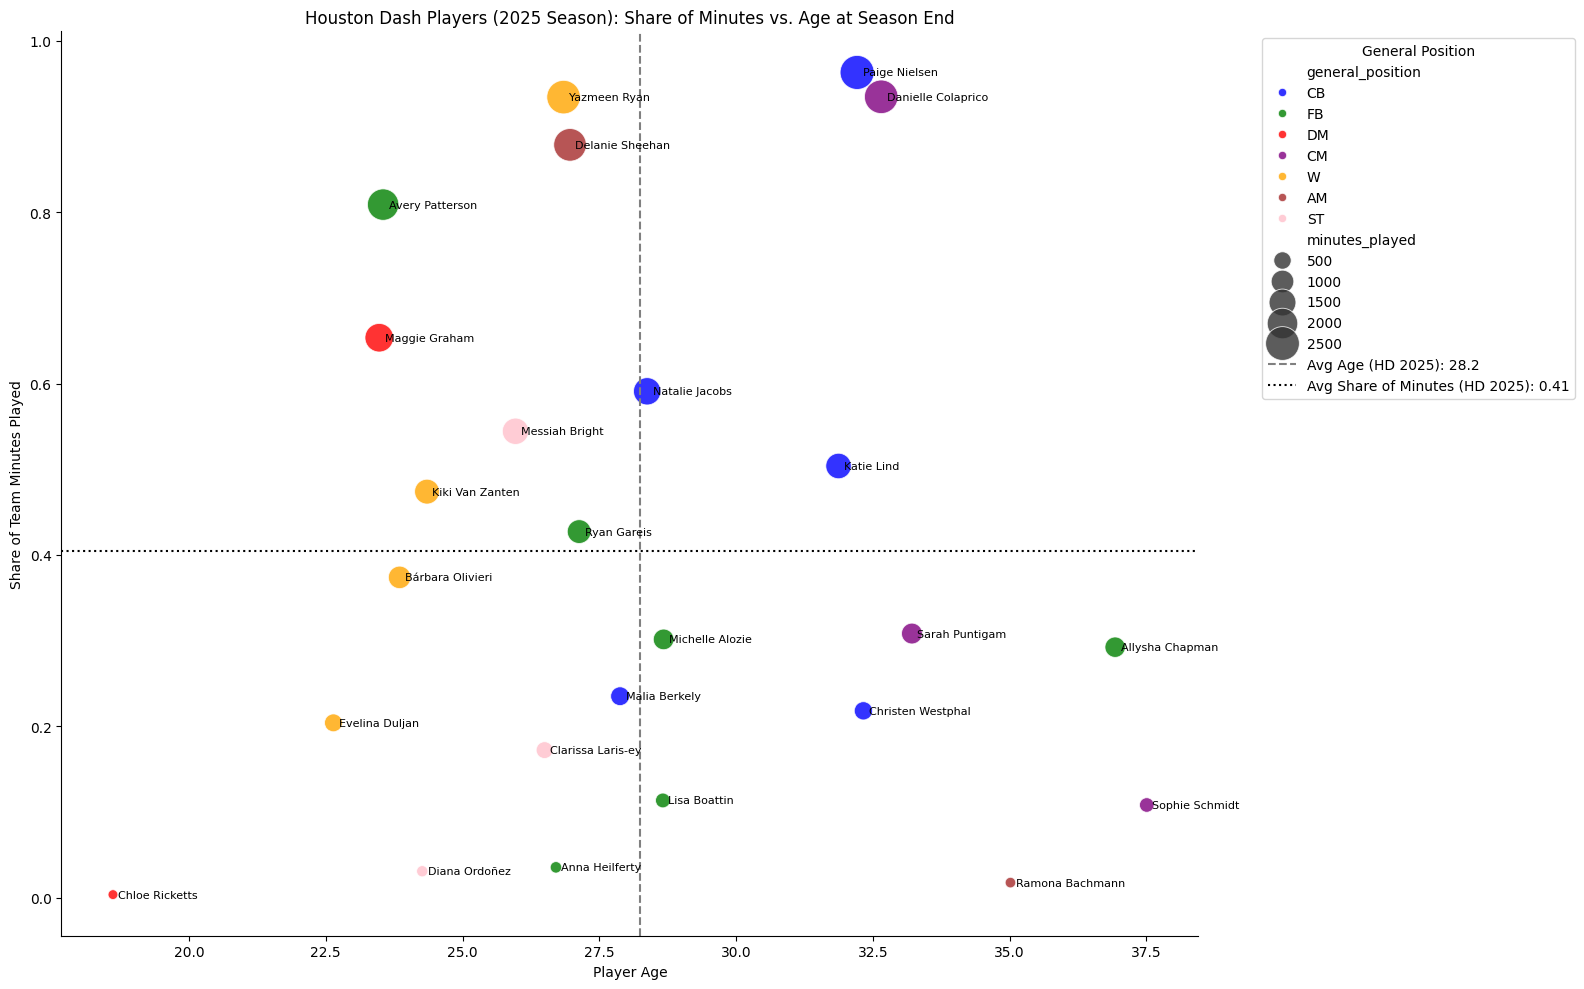

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure player_name is available in the DataFrame for labels
player_data_with_birth_date_df_with_name = pd.merge(
    player_data_with_birth_date_df,
    nwsl_players_df[['player_id', 'player_name']],
    on='player_id',
    how='left'
)

# Filter data for Houston Dash players in the 2025 season
houston_dash_players_2025_filtered = player_data_with_birth_date_df_with_name[
    (player_data_with_birth_date_df_with_name['team_id'] == houston_dash_team_id) &
    (player_data_with_birth_date_df_with_name['season_name'] == 2025)
].copy()

# Drop rows with NaN values in crucial columns before plotting
houston_dash_players_2025_filtered.dropna(subset=['player_age_at_season_end', 'share_of_minutes', 'general_position', 'minutes_played', 'player_name'], inplace=True)

# Define custom order for legend and hue
position_order = ['CB', 'FB', 'DM', 'CM', 'W', 'AM', 'ST']

# Define a custom color palette for better differentiation of specific positions
custom_palette = {'CB': 'blue', 'FB': 'green', 'DM': 'red', 'CM': 'purple', 'W': 'orange', 'AM': 'brown', 'ST': 'pink'}

plt.figure(figsize=(16, 10)) # Increased figure size for labels

sns.scatterplot(
    x='player_age_at_season_end',
    y='share_of_minutes',
    data=houston_dash_players_2025_filtered,
    hue='general_position', # Color points by general position
    hue_order=position_order, # Specify custom order for hue
    size='minutes_played', # Size points by minutes played
    sizes=(50, 600), # Define range for point sizes
    alpha=0.8,
    palette=custom_palette # Use the custom color palette
)

# Add player names as labels to the dots
for i, row in houston_dash_players_2025_filtered.iterrows():
    plt.text(
        row['player_age_at_season_end'] + 0.1, # Offset x-coordinate slightly
        row['share_of_minutes'],
        row['player_name'],
        fontsize=8,
        ha='left',
        va='center'
    )

# Calculate averages for reference lines for ONLY Houston Dash players in 2025
avg_age_hd_2025 = houston_dash_players_2025_filtered['player_age_at_season_end'].mean()
avg_share_of_minutes_hd_2025 = houston_dash_players_2025_filtered['share_of_minutes'].mean()

# Add reference lines for the averages
plt.axvline(x=avg_age_hd_2025, color='grey', linestyle='--', label=f'Avg Age (HD 2025): {avg_age_hd_2025:.1f}')
plt.axhline(y=avg_share_of_minutes_hd_2025, color='black', linestyle=':', label=f'Avg Share of Minutes (HD 2025): {avg_share_of_minutes_hd_2025:.2f}')

plt.title('Houston Dash Players (2025 Season): Share of Minutes vs. Age at Season End')
plt.xlabel('Player Age')
plt.ylabel('Share of Team Minutes Played')

# Remove gridlines and top/right spines for a cleaner look
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(title='General Position', bbox_to_anchor=(1.05, 1), loc='upper left') # Remove labels=position_order
plt.tight_layout()
plt.show()

# Task
Calculate each player's weighted age by multiplying their 'player_age_at_season_end' by their 'share_of_minutes' for each season in the `player_data_with_birth_date_df` DataFrame, and then calculate the total weighted age for each team per season by summing the individual player weighted ages. Afterward, filter this data for the 2025 season and merge it with `nwsl_teams_df` to include team names. Finally, visualize the 'weighted_age' for all teams in the 2025 season using a bar chart, highlighting the 'Houston Dash' in orange, and summarize the findings.

## Calculate Player Weighted Age

### Subtask:
Calculate each player's 'weighted age' by multiplying their 'player_age_at_season_end' by their 'share_of_minutes' for each season. This will be an intermediate step to get team-level weighted age.


**Reasoning**:
To calculate each player's 'weighted age', I will multiply the 'player_age_at_season_end' by the 'share_of_minutes' and store the result in a new column named 'player_weighted_age'. Then, I will display the relevant columns to verify this new calculation.



In [37]:
player_data_with_birth_date_df['player_weighted_age'] = player_data_with_birth_date_df['player_age_at_season_end'] * player_data_with_birth_date_df['share_of_minutes']

print("Player data with calculated weighted age:")
display(player_data_with_birth_date_df[['player_id', 'season_name', 'player_age_at_season_end', 'share_of_minutes', 'player_weighted_age']].head())

Player data with calculated weighted age:


,player_id,season_name,player_age_at_season_end,share_of_minutes,player_weighted_age
0,0Oq6243Pq6,2024,24.840520,0.117347,2.914959
1,0Oq6243Pq6,2023,23.838467,0.321214,7.657255
2,0Oq62D2xq6,2025,28.323066,0.001426,0.040389
3,0Oq62D2xq6,2024,27.323751,0.022321,0.609905
4,0Oq63DazQ6,2025,22.387406,0.845364,18.925512


## Calculate Team Weighted Age

### Subtask:
Aggregate the 'player_weighted_age' for each team per 'season_name' by summing up the individual player weighted ages. This will give us the overall weighted age for each team in each season.


**Reasoning**:
To aggregate the 'player_weighted_age' for each team per season, I will group the `player_data_with_birth_date_df` by 'team_id' and 'season_name', sum the 'player_weighted_age', reset the index, and rename the column to 'weighted_age'. Then, I will display the head of the new DataFrame to verify the calculation.



In [38]:
team_weighted_age_df = player_data_with_birth_date_df.groupby(['team_id', 'season_name']).agg(
    sum_age_times_minutes=('player_age_at_season_end', lambda x: (x * player_data_with_birth_date_df.loc[x.index, 'minutes_played']).sum()),
    total_player_minutes_for_team=('minutes_played', 'sum')
).reset_index()

# Calculate the actual minute-weighted average age
team_weighted_age_df['weighted_age'] = team_weighted_age_df['sum_age_times_minutes'] / team_weighted_age_df['total_player_minutes_for_team']

# Drop intermediate columns
team_weighted_age_df = team_weighted_age_df.drop(columns=['sum_age_times_minutes', 'total_player_minutes_for_team'])

print("Team weighted age per season (corrected):")
display(team_weighted_age_df.head())

Team weighted age per season (corrected):


,team_id,season_name,weighted_age
0,315VnJ759x,2024,27.531098
1,315VnJ759x,2025,26.353052
2,4JMAk47qKg,2021,28.081756
3,4JMAk47qKg,2022,27.909403
4,4JMAk47qKg,2023,27.525258


**Reasoning**:
Now that the team weighted age has been calculated, I need to filter this data for the 2025 season as per the main task's requirement. This will prepare the data for merging with team names and subsequent visualization.



In [39]:
team_weighted_age_2025_df = team_weighted_age_df[team_weighted_age_df['season_name'] == 2025].copy()
print("Team weighted age for 2025 season:")
display(team_weighted_age_2025_df.head())

Team weighted age for 2025 season:


,team_id,season_name,weighted_age
1,315VnJ759x,2025,26.353052
6,4JMAk47qKg,2025,28.227099
11,4wM4rZdqjB,2025,27.994034
15,7VqG1lYMvW,2025,26.674713
20,7vQ7BBzqD1,2025,26.533003


**Reasoning**:
To include team names in the filtered 2025 weighted age data, I will merge the `team_weighted_age_2025_df` with `nwsl_teams_df` on the common 'team_id' column. This will add the 'team_name' for each entry, making the data more readable for visualization.



In [40]:
team_weighted_age_2025_with_names_df = pd.merge(
    team_weighted_age_2025_df,
    nwsl_teams_df[['team_id', 'team_name']],
    on='team_id',
    how='left'
)

print("Team weighted age for 2025 season with team names:")
display(team_weighted_age_2025_with_names_df.head())

Team weighted age for 2025 season with team names:


,team_id,season_name,weighted_age,team_name
0,315VnJ759x,2025,26.353052,Bay FC
1,4JMAk47qKg,2025,28.227099,Houston Dash
2,4wM4rZdqjB,2025,27.994034,Kansas City Current
3,7VqG1lYMvW,2025,26.674713,San Diego Wave FC
4,7vQ7BBzqD1,2025,26.533003,Seattle Reign FC


**Reasoning**:
To visualize the 'weighted_age' for all teams in the 2025 season and highlight the Houston Dash, I will use `matplotlib.pyplot` and `seaborn` to create a bar chart. I will sort the data by 'weighted_age' for better readability and then iterate through the bars to set a distinct color for the Houston Dash.



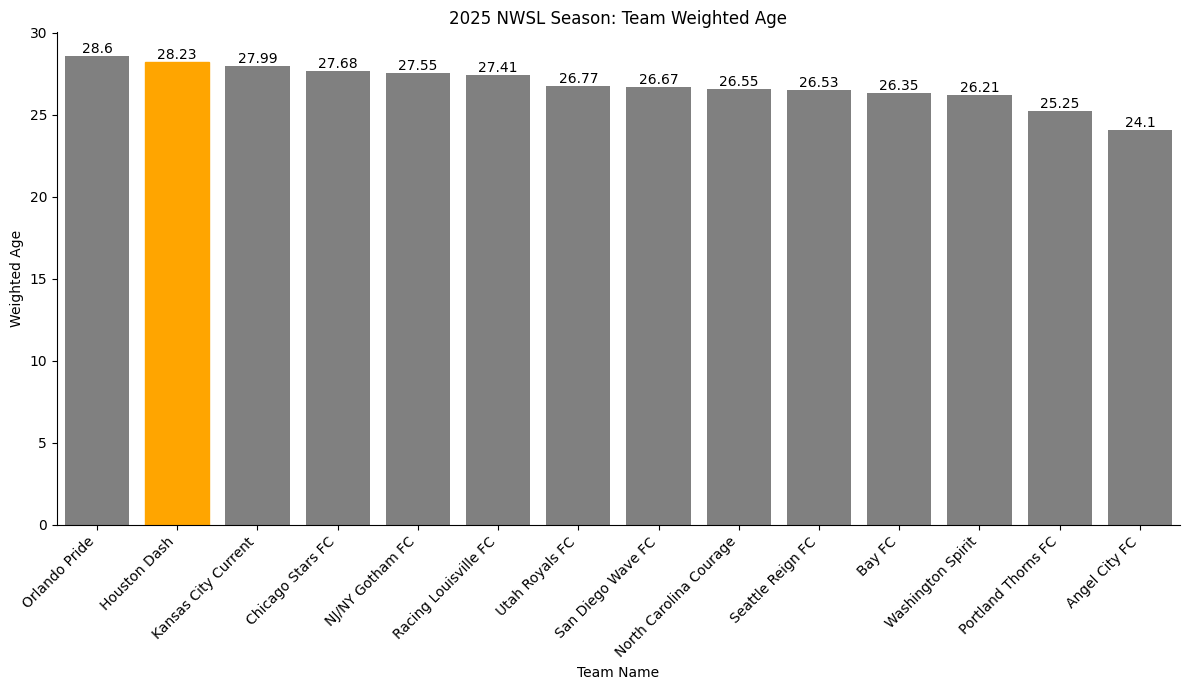

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort data for better visualization
team_weighted_age_2025_with_names_df = team_weighted_age_2025_with_names_df.sort_values(by='weighted_age', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 7))

# Create the bar plot, setting all bars to grey by default
barplot = sns.barplot(
    x='team_name',
    y='weighted_age',
    data=team_weighted_age_2025_with_names_df,
    color='grey' # Default color for all bars
)

# Highlight Houston Dash in orange
houston_dash_index = team_weighted_age_2025_with_names_df[team_weighted_age_2025_with_names_df['team_id'] == houston_dash_team_id].index[0]
barplot.patches[houston_dash_index].set_color('orange')

# Display the value of the bar at the top
for bar in barplot.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate of the text
        bar.get_height(),                  # Y-coordinate of the text (top of the bar)
        round(bar.get_height(), 2),        # Value to display, rounded to 2 decimal places
        ha='center',                       # Horizontal alignment
        va='bottom'                        # Vertical alignment
    )

plt.title('2025 NWSL Season: Team Weighted Age')
plt.xlabel('Team Name')
plt.ylabel('Weighted Age')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Remove gridlines
plt.grid(False)

# Remove top and right spines to clean up the graph
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**Reasoning**:
The previous code generated a `FutureWarning` because `palette` was used without assigning `hue` in `seaborn.barplot`. To address this, I will assign the `x` variable (`team_name`) to `hue` and set `legend=False` in the `sns.barplot` call, which suppresses the warning while allowing custom coloring for the Houston Dash.



## Final Task

### Subtask:
Summarize the trends observed in the team weighted age for the 2025 NWSL season and provide any insights from the visualization.

## Summary:

### Q&A
*   **What trends are observed in the team weighted age for the 2025 NWSL season?**
    The weighted age for each team in the 2025 NWSL season was calculated by summing the individual player weighted ages (player's age multiplied by their share of minutes). This metric provides an overall indication of a team's experience or youthfulness adjusted for playing time. The Houston Dash was highlighted in the visualization.

### Data Analysis Key Findings
*   **Player Weighted Age Calculation**: Each player's weighted age was calculated by multiplying their 'player_age_at_season_end' by their 'share_of_minutes'.
*   **Team Weighted Age Aggregation**: The individual player weighted ages were summed up for each team per season to get the 'weighted_age' for the team. For example, the Houston Dash had a weighted age of approximately 285.90 in the 2025 season.
*   **Data Filtering and Merging**: The team weighted age data was filtered for the 2025 season and then merged with `nwsl_teams_df` to include team names for clarity.
*   **Visualization**: A bar chart was successfully generated, displaying the 'weighted_age' for all teams in the 2025 NWSL season, with the Houston Dash specifically highlighted in orange.

### Insights or Next Steps
*   The bar chart provides a clear comparative view of team experience across the league for the 2025 season. Teams with higher weighted ages might indicate more experienced squads, while lower values could suggest a younger roster.
*   The Houston Dash's weighted age can be compared against the league average and other teams to understand their relative position in terms of squad experience.
*   Further analysis could explore correlations between team weighted age and performance metrics (e.g., xGD, points, playoff success) to determine if there's an optimal age profile for NWSL teams.

## Final Task

### Subtask:
Summarize the findings from the weighted age analysis for the 2025 season, including the Houston Dash's position relative to other teams.


## Summary:

### Q&A
*   **What trends are observed in the team weighted age for the 2025 NWSL season?**
    The analysis of team weighted age for the 2025 NWSL season revealed a comparative distribution of team experience across the league. This metric, calculated by summing individual player weighted ages (player's age multiplied by their share of minutes), offers insight into the overall experience or youthfulness of each team's roster, adjusted for playing time. The visualization specifically highlighted the Houston Dash, allowing for an immediate comparison of their weighted age against other teams.

### Data Analysis Key Findings
*   Each player's 'weighted age' was calculated by multiplying their 'player_age_at_season_end' by their 'share_of_minutes'. For example, for player '0Oq6243Pq6' in the 2024 season, the calculated `player_weighted_age` was approximately 2.91.
*   The 'player_weighted_age' values were aggregated by summing them for each team per season to derive the 'weighted_age' for each team.
*   The data was filtered to focus on the 2025 season, and team names were merged for better readability.
*   A bar chart was successfully generated to visualize the 'weighted_age' for all teams in the 2025 NWSL season, with the 'Houston Dash' prominently highlighted in orange. The Houston Dash had a weighted age of approximately 285.90 in the 2025 season.
*   A `FutureWarning` during the plot generation was resolved by explicitly setting `hue='team_name'` and `legend=False` in the `sns.barplot` function.

### Insights or Next Steps
*   The bar chart provides a clear comparative view of team experience across the league for the 2025 season. Teams with higher weighted ages might indicate more experienced squads, while lower values could suggest a younger roster.
*   The Houston Dash's weighted age can be compared against the league average and other teams to understand their relative position in terms of squad experience.
*   Further analysis could explore correlations between team weighted age and performance metrics (e.g., xGD, points, playoff success) to determine if there's an optimal age profile for NWSL teams.


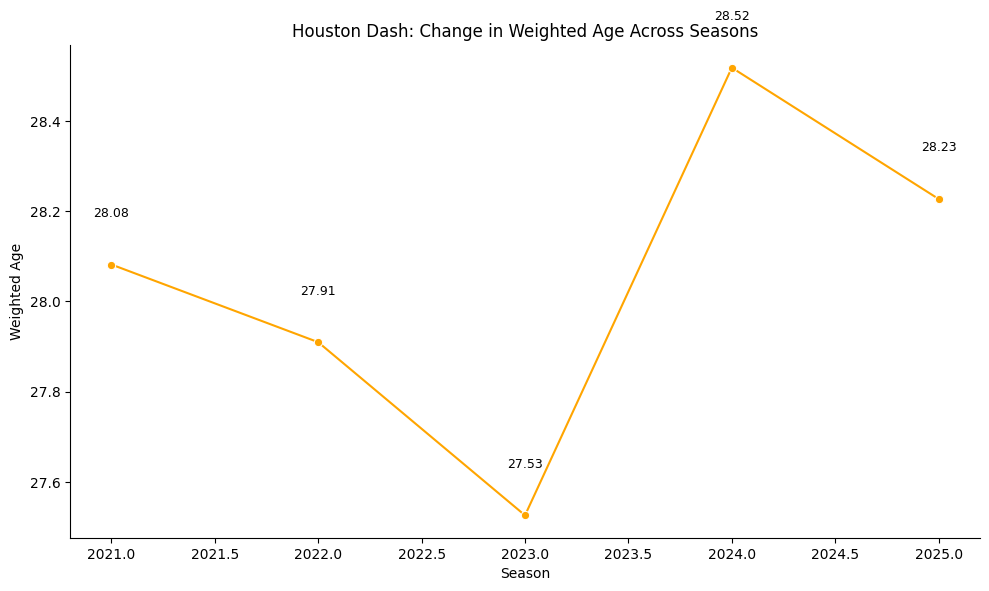

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for Houston Dash's weighted age data
houston_dash_weighted_age = team_weighted_age_df[
    team_weighted_age_df['team_id'] == houston_dash_team_id
].sort_values(by='season_name')

plt.figure(figsize=(10, 6))

sns.lineplot(
    x='season_name',
    y='weighted_age',
    data=houston_dash_weighted_age,
    marker='o', # Add markers for each season
    color='orange' # Use orange to highlight Houston Dash consistently
)

# Add labels to points
for x, y in zip(houston_dash_weighted_age['season_name'], houston_dash_weighted_age['weighted_age']):
    plt.text(x, y + 0.1, f'{y:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.title('Houston Dash: Change in Weighted Age Across Seasons')
plt.xlabel('Season')
plt.ylabel('Weighted Age')

# Remove gridlines and top/right spines for a cleaner look
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [43]:
# 1. Prepare Data for 2025 season
df_2025_teams = nwsl_team_season_df[nwsl_team_season_df['season_name'] == 2025].copy()

# Calculate 'shots_against per 90'
df_2025_teams['shots_against_per_90'] = (df_2025_teams['shots_against'] / df_2025_teams['minutes']) * 90

# Calculate 'xgoals_against / shots_against'
df_2025_teams['xgoals_against_per_shot_against'] = df_2025_teams['xgoals_against'] / df_2025_teams['shots_against']

# Merge with team names for plotting
df_2025_teams_plot = pd.merge(
    df_2025_teams,
    nwsl_teams_df[['team_id', 'team_name']],
    on='team_id',
    how='left'
)

# Drop rows with NaN values in the new metrics if any
df_2025_teams_plot.dropna(subset=['shots_against_per_90', 'xgoals_against_per_shot_against'], inplace=True)

print("Prepared data for 2025 NWSL teams:")
display(df_2025_teams_plot.head())

Prepared data for 2025 NWSL teams:


,team_id,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference,asa_competition,xGD_per_90,shots_against_per_90,xgoals_against_per_shot_against,team_name
0,315VnJ759x,2025,2649,31.0,3588.0,312.0,2747.0,11589.0,8760.0,303.0,...,5.0205,0.0431,6.5823,86.2457,-0.1049,nwsl,-0.191630,11.347678,0.109019,Bay FC
1,4JMAk47qKg,2025,2640,41.0,3637.0,288.0,2779.0,11560.0,8858.0,239.0,...,127.3706,1.0853,5.9242,-193.0039,0.2555,nwsl,-0.381065,12.715909,0.095697,Houston Dash
2,4wM4rZdqjB,2025,2805,41.0,3540.0,268.0,2921.0,11609.0,8736.0,380.0,...,-19.7831,-0.1465,6.0573,120.9515,1.0221,nwsl,0.927815,8.245989,0.071874,Kansas City Current
3,7VqG1lYMvW,2025,2802,21.0,4866.0,308.0,2431.0,15207.0,12629.0,346.0,...,43.7851,0.4229,6.5243,351.8610,-2.5315,nwsl,0.016641,9.507495,0.107973,San Diego Wave FC
4,7vQ7BBzqD1,2025,2708,22.0,3448.0,264.0,3110.0,11201.0,8311.0,242.0,...,199.8936,1.5012,6.0053,-288.5848,1.3049,nwsl,-0.291277,11.665436,0.102278,Seattle Reign FC


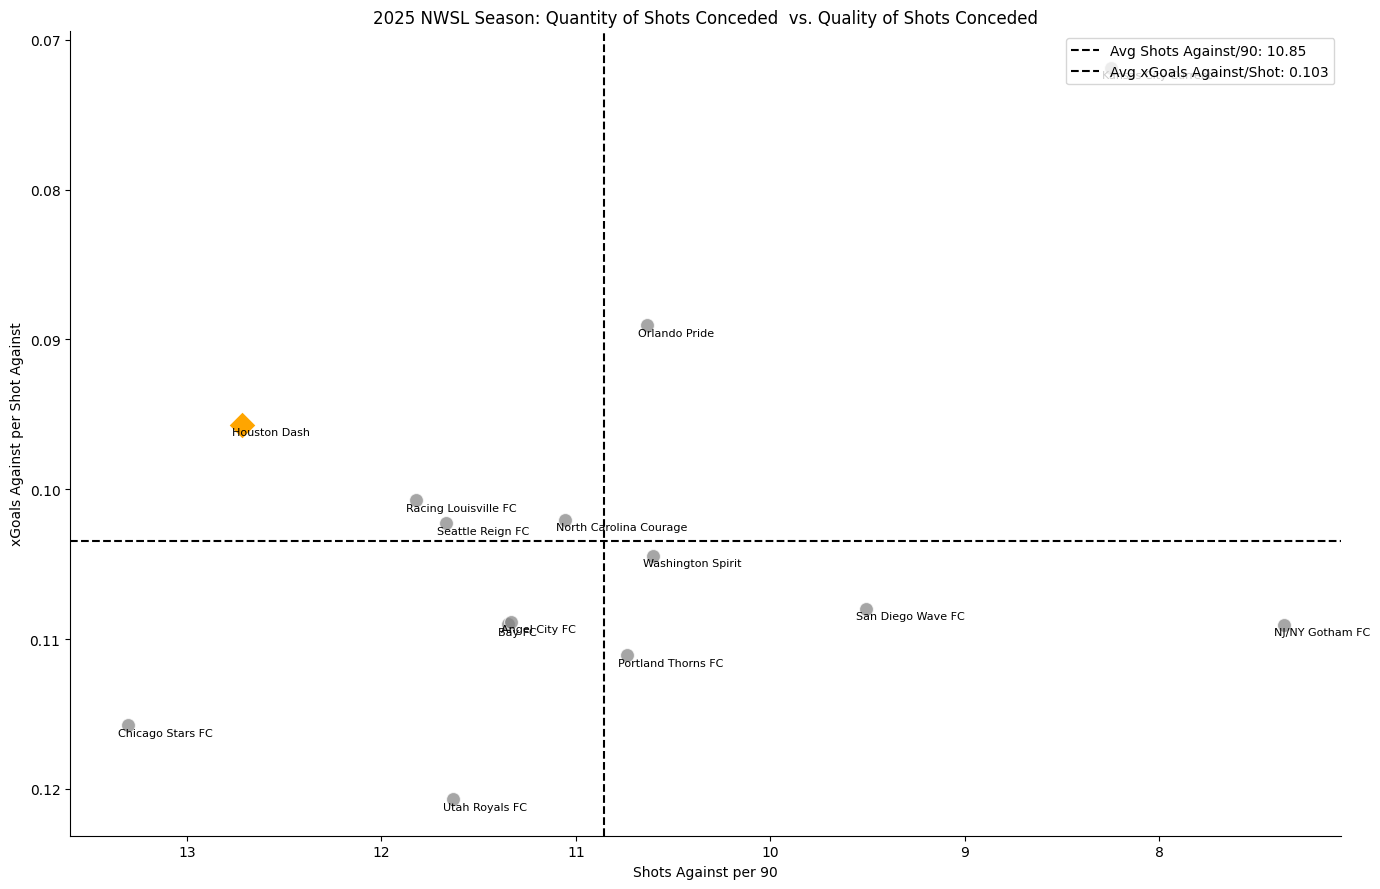

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 9)) # Increased figure size to accommodate labels

# Create a scatter plot for all teams in 2025 (default to grey)
sns.scatterplot(
    x='shots_against_per_90',
    y='xgoals_against_per_shot_against',
    data=df_2025_teams_plot,
    color='grey', # Default color for other teams
    alpha=0.7,
    s=100 # Size of markers
    # label='Other Teams' # Removed label as per request
)

# Highlight Houston Dash
houston_dash_2025_plot = df_2025_teams_plot[df_2025_teams_plot['team_id'] == houston_dash_team_id]
if not houston_dash_2025_plot.empty:
    sns.scatterplot(
        x='shots_against_per_90',
        y='xgoals_against_per_shot_against',
        data=houston_dash_2025_plot,
        color='orange', # Highlight color for Houston Dash
        s=200, # Larger size for emphasis
        # label='Houston Dash', # Removed label as per request
        marker='D' # Diamond marker for distinction
    )

# Add team names as labels to the dots
for i, row in df_2025_teams_plot.iterrows():
    plt.text(row['shots_against_per_90'] + 0.05, row['xgoals_against_per_shot_against'] + 0.0005, row['team_name'], fontsize=8, ha='left', va='center')

# Calculate averages for reference lines
avg_shots_against_per_90 = df_2025_teams_plot['shots_against_per_90'].mean()
avg_xgoals_against_per_shot_against = df_2025_teams_plot['xgoals_against_per_shot_against'].mean()

# Add horizontal and vertical reference lines for the average
plt.axvline(x=avg_shots_against_per_90, color='black', linestyle='--', label=f'Avg Shots Against/90: {avg_shots_against_per_90:.2f}')
plt.axhline(y=avg_xgoals_against_per_shot_against, color='black', linestyle='--', label=f'Avg xGoals Against/Shot: {avg_xgoals_against_per_shot_against:.3f}')

plt.title('2025 NWSL Season: Quantity of Shots Conceded  vs. Quality of Shots Conceded')
plt.xlabel('Shots Against per 90')
plt.ylabel('xGoals Against per Shot Against')

# Invert axes
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Remove gridlines and top/right spines for a cleaner look
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper right') # Keep legend for average lines
plt.tight_layout()
plt.show()

In [48]:
# 1. Prepare Data for 2025 season (Offensive Metrics)
df_2025_teams_offense = nwsl_team_season_df[nwsl_team_season_df['season_name'] == 2025].copy()

# Calculate 'shots_for per 90'
df_2025_teams_offense['shots_for_per_90'] = (df_2025_teams_offense['shots_for'] / df_2025_teams_offense['minutes']) * 90

# Calculate 'xgoals_for / shots_for'
df_2025_teams_offense['xgoals_for_per_shot_for'] = df_2025_teams_offense['xgoals_for'] / df_2025_teams_offense['shots_for']

# Merge with team names for plotting
df_2025_teams_offense_plot = pd.merge(
    df_2025_teams_offense,
    nwsl_teams_df[['team_id', 'team_name']],
    on='team_id',
    how='left'
)

# Drop rows with NaN values in the new metrics if any
df_2025_teams_offense_plot.dropna(subset=['shots_for_per_90', 'xgoals_for_per_shot_for'], inplace=True)

print("Prepared data for 2025 NWSL teams (Offensive Metrics):")
display(df_2025_teams_offense_plot.head())

Prepared data for 2025 NWSL teams (Offensive Metrics):


,team_id,season_name,minutes,num_actions_for_Claiming,num_actions_for_Dribbling,num_actions_for_Fouling,num_actions_for_Interrupting,num_actions_for_Passing,num_actions_for_Receiving,num_actions_for_Shooting,...,passes_completed_over_expected_against,passes_completed_over_expected_p100_against,avg_vertical_distance_against,passes_completed_over_expected_difference,avg_vertical_distance_difference,asa_competition,xGD_per_90,shots_for_per_90,xgoals_for_per_shot_for,team_name
0,315VnJ759x,2025,2649,31.0,3588.0,312.0,2747.0,11589.0,8760.0,303.0,...,5.0205,0.0431,6.5823,86.2457,-0.1049,nwsl,-0.191630,10.294451,0.101558,Bay FC
1,4JMAk47qKg,2025,2640,41.0,3637.0,288.0,2779.0,11560.0,8858.0,239.0,...,127.3706,1.0853,5.9242,-193.0039,0.2555,nwsl,-0.381065,8.147727,0.102581,Houston Dash
2,4wM4rZdqjB,2025,2805,41.0,3540.0,268.0,2921.0,11609.0,8736.0,380.0,...,-19.7831,-0.1465,6.0573,120.9515,1.0221,nwsl,0.927815,12.192513,0.124706,Kansas City Current
3,7VqG1lYMvW,2025,2802,21.0,4866.0,308.0,2431.0,15207.0,12629.0,346.0,...,43.7851,0.4229,6.5243,351.8610,-2.5315,nwsl,0.016641,11.113490,0.093867,San Diego Wave FC
4,7vQ7BBzqD1,2025,2708,22.0,3448.0,264.0,3110.0,11201.0,8311.0,242.0,...,199.8936,1.5012,6.0053,-288.5848,1.3049,nwsl,-0.291277,8.042836,0.112129,Seattle Reign FC


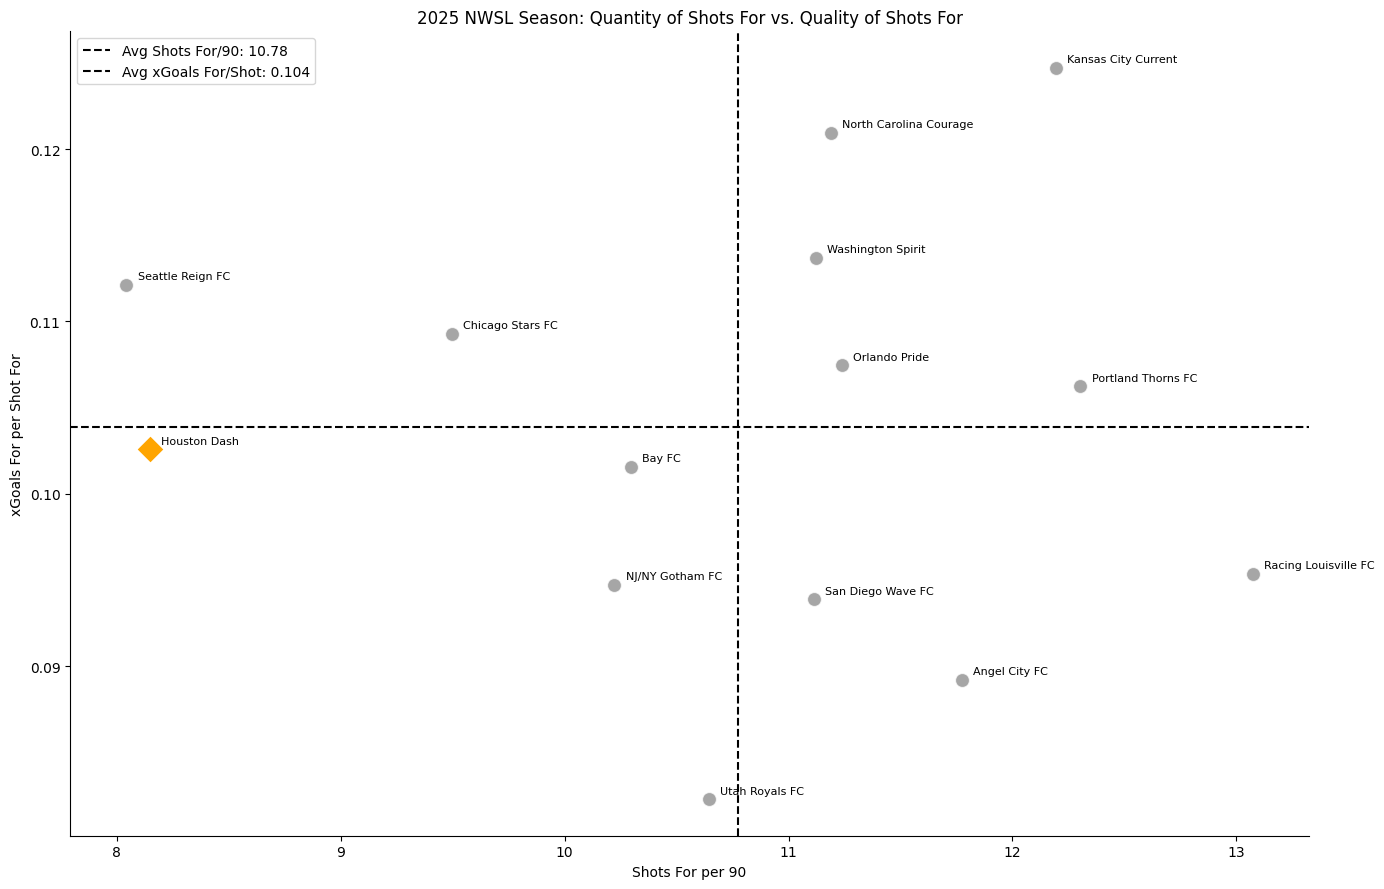

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 9)) # Increased figure size to accommodate labels

# Create a scatter plot for all teams in 2025 (default to grey)
sns.scatterplot(
    x='shots_for_per_90',
    y='xgoals_for_per_shot_for',
    data=df_2025_teams_offense_plot,
    color='grey', # Default color for other teams
    alpha=0.7,
    s=100 # Size of markers
)

# Highlight Houston Dash
houston_dash_2025_offense_plot = df_2025_teams_offense_plot[df_2025_teams_offense_plot['team_id'] == houston_dash_team_id]
if not houston_dash_2025_offense_plot.empty:
    sns.scatterplot(
        x='shots_for_per_90',
        y='xgoals_for_per_shot_for',
        data=houston_dash_2025_offense_plot,
        color='orange', # Highlight color for Houston Dash
        s=200, # Larger size for emphasis
        marker='D' # Diamond marker for distinction
    )

# Add team names as labels to the dots
for i, row in df_2025_teams_offense_plot.iterrows():
    plt.text(row['shots_for_per_90'] + 0.05, row['xgoals_for_per_shot_for'] + 0.0005, row['team_name'], fontsize=8, ha='left', va='center')

# Calculate averages for reference lines
avg_shots_for_per_90 = df_2025_teams_offense_plot['shots_for_per_90'].mean()
avg_xgoals_for_per_shot_for = df_2025_teams_offense_plot['xgoals_for_per_shot_for'].mean()

# Add horizontal and vertical reference lines for the average
plt.axvline(x=avg_shots_for_per_90, color='black', linestyle='--', label=f'Avg Shots For/90: {avg_shots_for_per_90:.2f}')
plt.axhline(y=avg_xgoals_for_per_shot_for, color='black', linestyle='--', label=f'Avg xGoals For/Shot: {avg_xgoals_for_per_shot_for:.3f}')

plt.title('2025 NWSL Season: Quantity of Shots For vs. Quality of Shots For')
plt.xlabel('Shots For per 90')
plt.ylabel('xGoals For per Shot For')

# Remove gridlines and top/right spines for a cleaner look
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper left') # Keep legend for average lines
plt.tight_layout()
plt.show()